In [9]:
from random import (choice, seed)
import pandas as pd

seed(1)

opções = [0, 1, 2 ,3, 4]

modelo = pd.read_csv("~/clusters/dados/clusters.csv")

c_clusters = {"EJs": list(modelo["EJs"])}

for dor in modelo.columns[1:]:
    c_clusters[dor] = [choice(opções) for _ in range(12)]
    
pd.DataFrame(c_clusters).set_index("EJs").to_csv("c_dados/c_clusters.csv")

In [10]:
#Traz as ferramentas que o Python precisa para se mover dentre
#as pastas do sistema operacional em que está sendo executado
import os

#Ensina o Python a encontrar os dados do diagnóstico
caminho_para_os_dados =  os.path.join("c_dados",
                                      "c_clusters.csv")

#Carrega a integração entre as linguagens R e Python
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R -i caminho_para_os_dados
#Chama a linguagem R e fornece o caminho para os dados do diagnóstico

#Carrega, silenciosamente, as ferramentas de análise
suppressMessages(library(tidyverse))

#Lê os dados e os formata para análise
entrada <- read.csv(caminho_para_os_dados)
entrada <- as_tibble(entrada)

#Processa e organiza os dados carregados 
processada <- entrada %>%
                  pivot_longer(
                       cols = -EJs,
                       names_to = c("Eixo", "Cluster", "Dores"),
                       names_pattern = "([A-Z]+)_([1-5])_([1-5])",
                       values_to = "Resposta")
    
#Agrupa os dados por EJ, Cluster e Eixo e calcula a média das
#respostas para cada um desses grupos
empresas_juniores <- processada %>%
                         group_by(EJs, Cluster, Eixo) %>%
                         summarise(Media=mean(Resposta))

#Gera uma base de dados para cada Eixo
ejs_por_MN <- empresas_juniores %>% filter(Eixo == "MN")
ejs_por_VM <- empresas_juniores %>% filter(Eixo == "VM")
ejs_por_TC <- empresas_juniores %>% filter(Eixo == "TC")
ejs_por_GO <- empresas_juniores %>% filter(Eixo == "GO")


#Agrupa os dados por EJ e Cluster e calcula a
#média das respostas para cada um desses grupos
ejs_por_cluster <- empresas_juniores %>%
                       group_by(EJs, Cluster) %>%
                       summarise(Media=mean(Media))

#Agrupa os dados por EJ e Eixo e calcula a
#média das respostas para cada um desses grupos
ejs_por_eixo <- empresas_juniores %>%
                    group_by(EJs, Eixo) %>%
                    summarize(Media=mean(Media))
        
#Agrupa os dados por Cluster, Eixo e Dores,
#calcula a média para cada grupo e organiza a tabela
#de modo que as dores mais presentes fiquem no topo
dores <- processada %>%
             group_by(Cluster, Eixo, Dores) %>%
             summarise(Media=mean(Resposta)) %>%
             arrange(desc(Media))

#Sumariza as dores por eixo
eixos <- dores %>%
             group_by(Eixo) %>%
             summarize(Media=mean(Media)) %>%
             arrange(desc(Media))
            
#Escreve as tabelas nos arquivos correspondentes
#dentro da pasta "resultados"
setwd("c_resultado")
write.csv(entrada, "entrada.csv", row.names = FALSE)
write.csv(processada, "processada.csv", row.names = FALSE)
write.csv(empresas_juniores, "empresas_juniores.csv", row.names = FALSE)
write.csv(ejs_por_MN, "ejs_por_MN.csv", row.names = FALSE)
write.csv(ejs_por_VM, "ejs_por_VM.csv", row.names = FALSE)
write.csv(ejs_por_TC, "ejs_por_TC.csv", row.names = FALSE)
write.csv(ejs_por_GO, "ejs_por_GO.csv", row.names = FALSE)
write.csv(ejs_por_cluster, "ejs_por_cluster.csv", row.names = FALSE)
write.csv(ejs_por_eixo, "ejs_por_eixo.csv", row.names = FALSE)
write.csv(dores, "dores.csv", row.names = FALSE)
write.csv(eixos, "eixos.csv", row.names = FALSE)
setwd("..")

#Mostra as primeiras linhas da tabela de dores
print(head(dores))

#Mostra o sumário por eixo
eixos

`summarise()` regrouping output by 'EJs', 'Cluster' (override with `.groups` argument)
`summarise()` regrouping output by 'EJs' (override with `.groups` argument)
`summarise()` regrouping output by 'EJs' (override with `.groups` argument)
`summarise()` regrouping output by 'Cluster', 'Eixo' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
# A tibble: 6 x 4
# Groups:   Cluster, Eixo [6]
  Cluster Eixo  Dores Media
  <chr>   <chr> <chr> <dbl>
1 1       VM    1      2.92
2 4       VM    1      2.67
3 5       MN    1      2.67
4 3       MN    1      2.58
5 3       TC    2      2.58
6 4       MN    2      2.58
# A tibble: 4 x 2
  Eixo  Media
  <chr> <dbl>
1 MN     2.21
2 TC     2.01
3 VM     2   
4 GO     1.94


In [12]:
#Traz uma ferramenta de cálculo numérico para o Python
import numpy as np

#Permite que o Python consiga verificar se uma dada
#variável é ou não um número
from numbers import Number

#Carrega um método de inversão de matrizes
from numpy.linalg import inv as inversa


#Dá forma ao conceito de Sinal de Cluster dentro do Pythom
class Sinal_de_Cluster:
    
    #Introduz a base canônica, isto é, aquela onde os sinais
    #estão em sua forma original ou não espalhada
    bases = {"c": ((1, 0, 0, 0, 0),
                   (0, 1, 0, 0, 0),
                   (0, 0, 1, 0, 0),
                   (0, 0, 0, 1, 0),
                   (0, 0, 0, 0, 1))
             }
    
    #Ensina o Python a definir uma nova base
    @classmethod
    def definir_base(cls, símbolo, matriz, normal=True):
        if not normal:
            cls.bases[símbolo] = matriz
        else:
            vetores_da_base = [[coord[i] for coord in matriz]
                                for i in range(len(matriz[0]))]
            sinais_da_base = [Sinal_de_Cluster(vetor)
                              for vetor in vetores_da_base]
            base_normalizada = [sinal/abs(sinal)
                                for sinal in sinais_da_base]
            cls.bases[símbolo] = [
                
                [base[i] for base in base_normalizada]
                 for i in range(len(base_normalizada[0]))
            ]
            
    #Ensina o Python a construir um Sinal de Cluster
    def __init__(self, vetor, base="c", name=None):
        self.base = base
        self.coordenadas = [coord for coord in vetor]
        self.pontos = [0] + self.coordenadas + [0]
        self.T = [[coord] for coord in vetor]
        if name is None: self.name="Sem Nome"
        else: self.name = name
        
    #Ensina o Python a calcular um produto interno     
    def interno(self, other):
        resultado = 0
        for i in range (7):
            k = 1
            if i == 0 or i == 6: k = 0.5
            resultado += k * self.pontos[i] * other.pontos[i]
        return resultado
    
    #Ensina o Python a normalizar um sinal, isto é, reduzí-lo a
    #uma versão que esteja a uma unidade de distância da origem,
    #ou seja, do sinal nulo
    def normalizado(self):
        return self/(abs(self))
    
    #Todas as definições a seguir servem para ensinar o Python a operar
    #os sinais, isto é, realizar somas, subtrações, multiplicações
    #e divisões entre eles.
    
    def __add__(self, other):
        vetor = [self.coordenadas[i]
                 + other.coordenadas[i]
                 for i in range(5)]
        return Sinal_de_Cluster(vetor, base=self.base)
    
    def __radd__(self, other):
        if other == 0:
            return self
    
    def __sub__(self, other):
        vetor = [self.coordenadas[i]
                 - other.coordenadas[i]
                 for i in range(5)]
        return Sinal_de_Cluster(vetor, base=self.base)
    
    def __mul__(self, other):
        if isinstance(other, Sinal_de_Cluster):
            return self.interno(other)
        elif isinstance(other, Number):
            return other*self
        else:
            raise NotImplementedError
            
    def __truediv__(self, other):
        if isinstance(other, Number):
            return self * (1/other)
    
    def __rmul__(self, other):
        if isinstance(other, Number):
            vetor = [other * coord for
                     coord in self.coordenadas]
            return Sinal_de_Cluster(vetor, base=self.base)
        else:
            raise NotImplementedError
    
    #Ensina o Python a calcular o módulo de um sinal, isto é,
    #sua distância à origem (sinal nulo)
    def __abs__(self):
        return float((self * self) ** (1/2))
    
    #Ensina o Python a calcular o número de dimensões de um sinal
    def __len__(self):
        return len(self.coordenadas)
    
    #Ensina o Python a ver as coordenadas do vetor que representa
    #o sinal
    def __getitem__(self, i):
        return self.coordenadas[i]
    
    #Ensina o Python a mudar um vetor de base
    def para_a_base(self, base):
        if base == self.base:
            return self
        else:
            atual_para_c = Sinal_de_Cluster.bases[self.base]
            c_para_base = inversa(
                np.array(Sinal_de_Cluster.bases[base]))
            array = c_para_base @ atual_para_c @ np.array(self.T)
            return Sinal_de_Cluster([n[0] for n in array],
                                    base=base, name=self.name)
        
    #As definições abaixo ensinam o Python a representar um vetor
    #de forma entendível por pessoas
    def __repr__(self):
        return self.name + ":\n" + np.array(self.T).__repr__(
               ) + "\nbase {}".format(self.base)
    
    def __str__(self):
        return self.name + ":" + np.array(self.T).__str__(
               ) + " base {}".format(self.base)
    

#Ensina como distribuir cada sinal unitário
matriz_da_base_C = (
    
    (8, 4, 2, 1, 1),
    (4, 8, 4, 2, 1),
    (2, 4, 8, 4, 2),
    (1, 2, 4, 8, 4),
    (1, 1, 2, 4, 8))

#Define a base onde os sinais se encontram distribuídos
Sinal_de_Cluster.definir_base(
         "C", matriz_da_base_C)

O próximo passo é processar os dados de cada EJ como sinais:

In [13]:
#Traz uma ferramenta de análise de dados tabelados para o Python
import pandas as pd

#Recupera as tabelas com os dados previamente processados pelo R
%R -o ejs_por_cluster 

#Recupera o nome de cada EJ
EJs = pd.unique(ejs_por_cluster["EJs"])

#Cria uma lista vazia para adicionar os sinais
sinais = []

#Para cada EJ dentre todas as EJs
for EJ in EJs:
    
    #Extrai as linhas da tabela que tratam da EJ
    linhas_da_EJ = ejs_por_cluster[ejs_por_cluster["EJs"] == EJ]
    
    #Cria uma lista vazia para preencher com o seu sinal
    sinal = []
    
    #Para cada linha dentre todas as linhas
    for índice, linha in linhas_da_EJ.iterrows():
        
        #Adiciona o valor do sinal de cada cluster
        sinal.append(linha["Media"])
        
    #Adiciona o sinal à lista de sinais identificando a EJ
    sinais.append((EJ, sinal))

#Processa os sinais para que seja possível trabalhar com eles
sinais_das_EJs = [Sinal_de_Cluster(sinal, base="C", name=EJ).para_a_base("c")
                  for EJ, sinal in sinais]

Enxergando os sinais das 3 primeiras EJs:

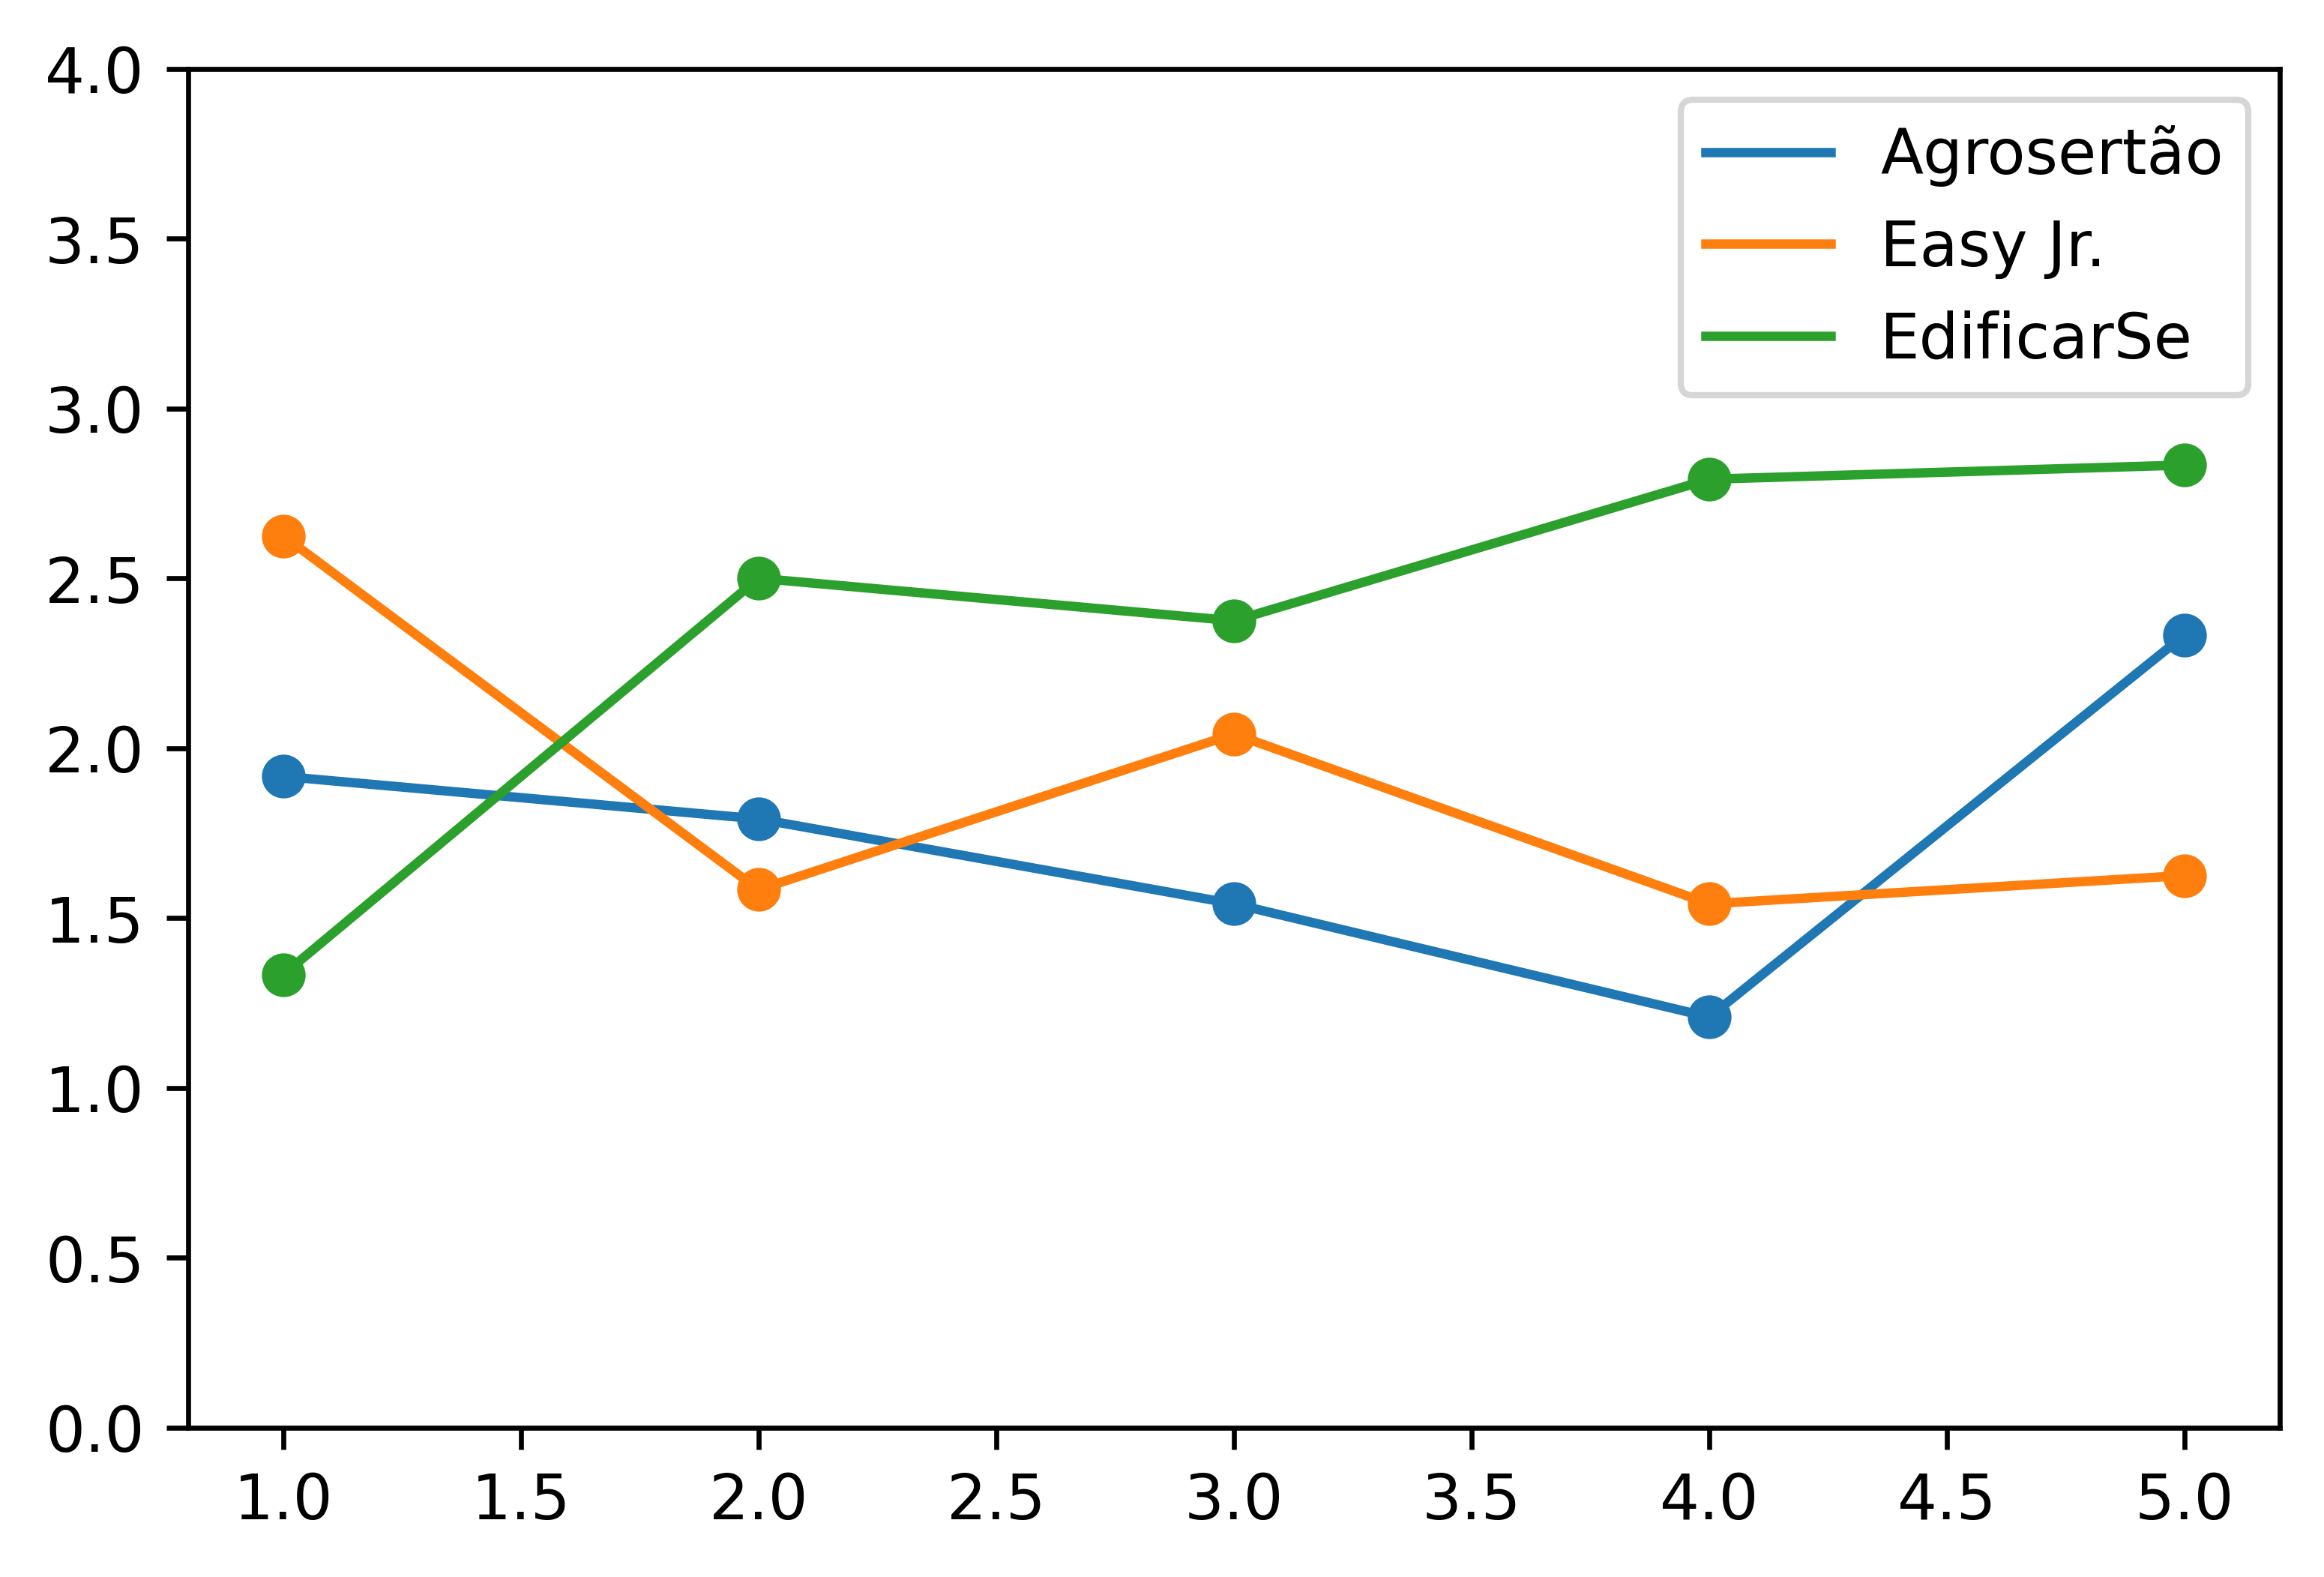

In [14]:
#Carrega as ferramentas de criação de gráficos
%matplotlib inline
from matplotlib import pyplot as plt

#Aumenta a qualidade dos gráficos
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

#Configura o eixo X do gráfico
X =[0, 1, 2, 3, 4, 5, 6]

#Mostra os sinais das 3 primeiras EJs
for sinal_de_EJ in sinais_das_EJs[:3]:
    
    #Traduz o sinal para base de entrada
    sinal_de_EJ = sinal_de_EJ.para_a_base("C")
    
    #Joga o sinal no gráfico
    plt.plot(X[1:-1], sinal_de_EJ.pontos[1:-1])
    plt.scatter(X[1:-1], sinal_de_EJ.pontos[1:-1])

#Define os limites do eixo y    
plt.ylim((0, 4))

#Adiciona uma legenda com os nomes das EJs do gráfico
plt.legend([sinal_de_EJ.name for sinal_de_EJ in sinais_das_EJs[:3]])

Interpretando o gráfico acima, notamos que as dores se acumulam de acordo com os clusters de maneira quase linear. Calculando a média dos sinais de todas as EJs, tem-se:

(0.0, 4.0)

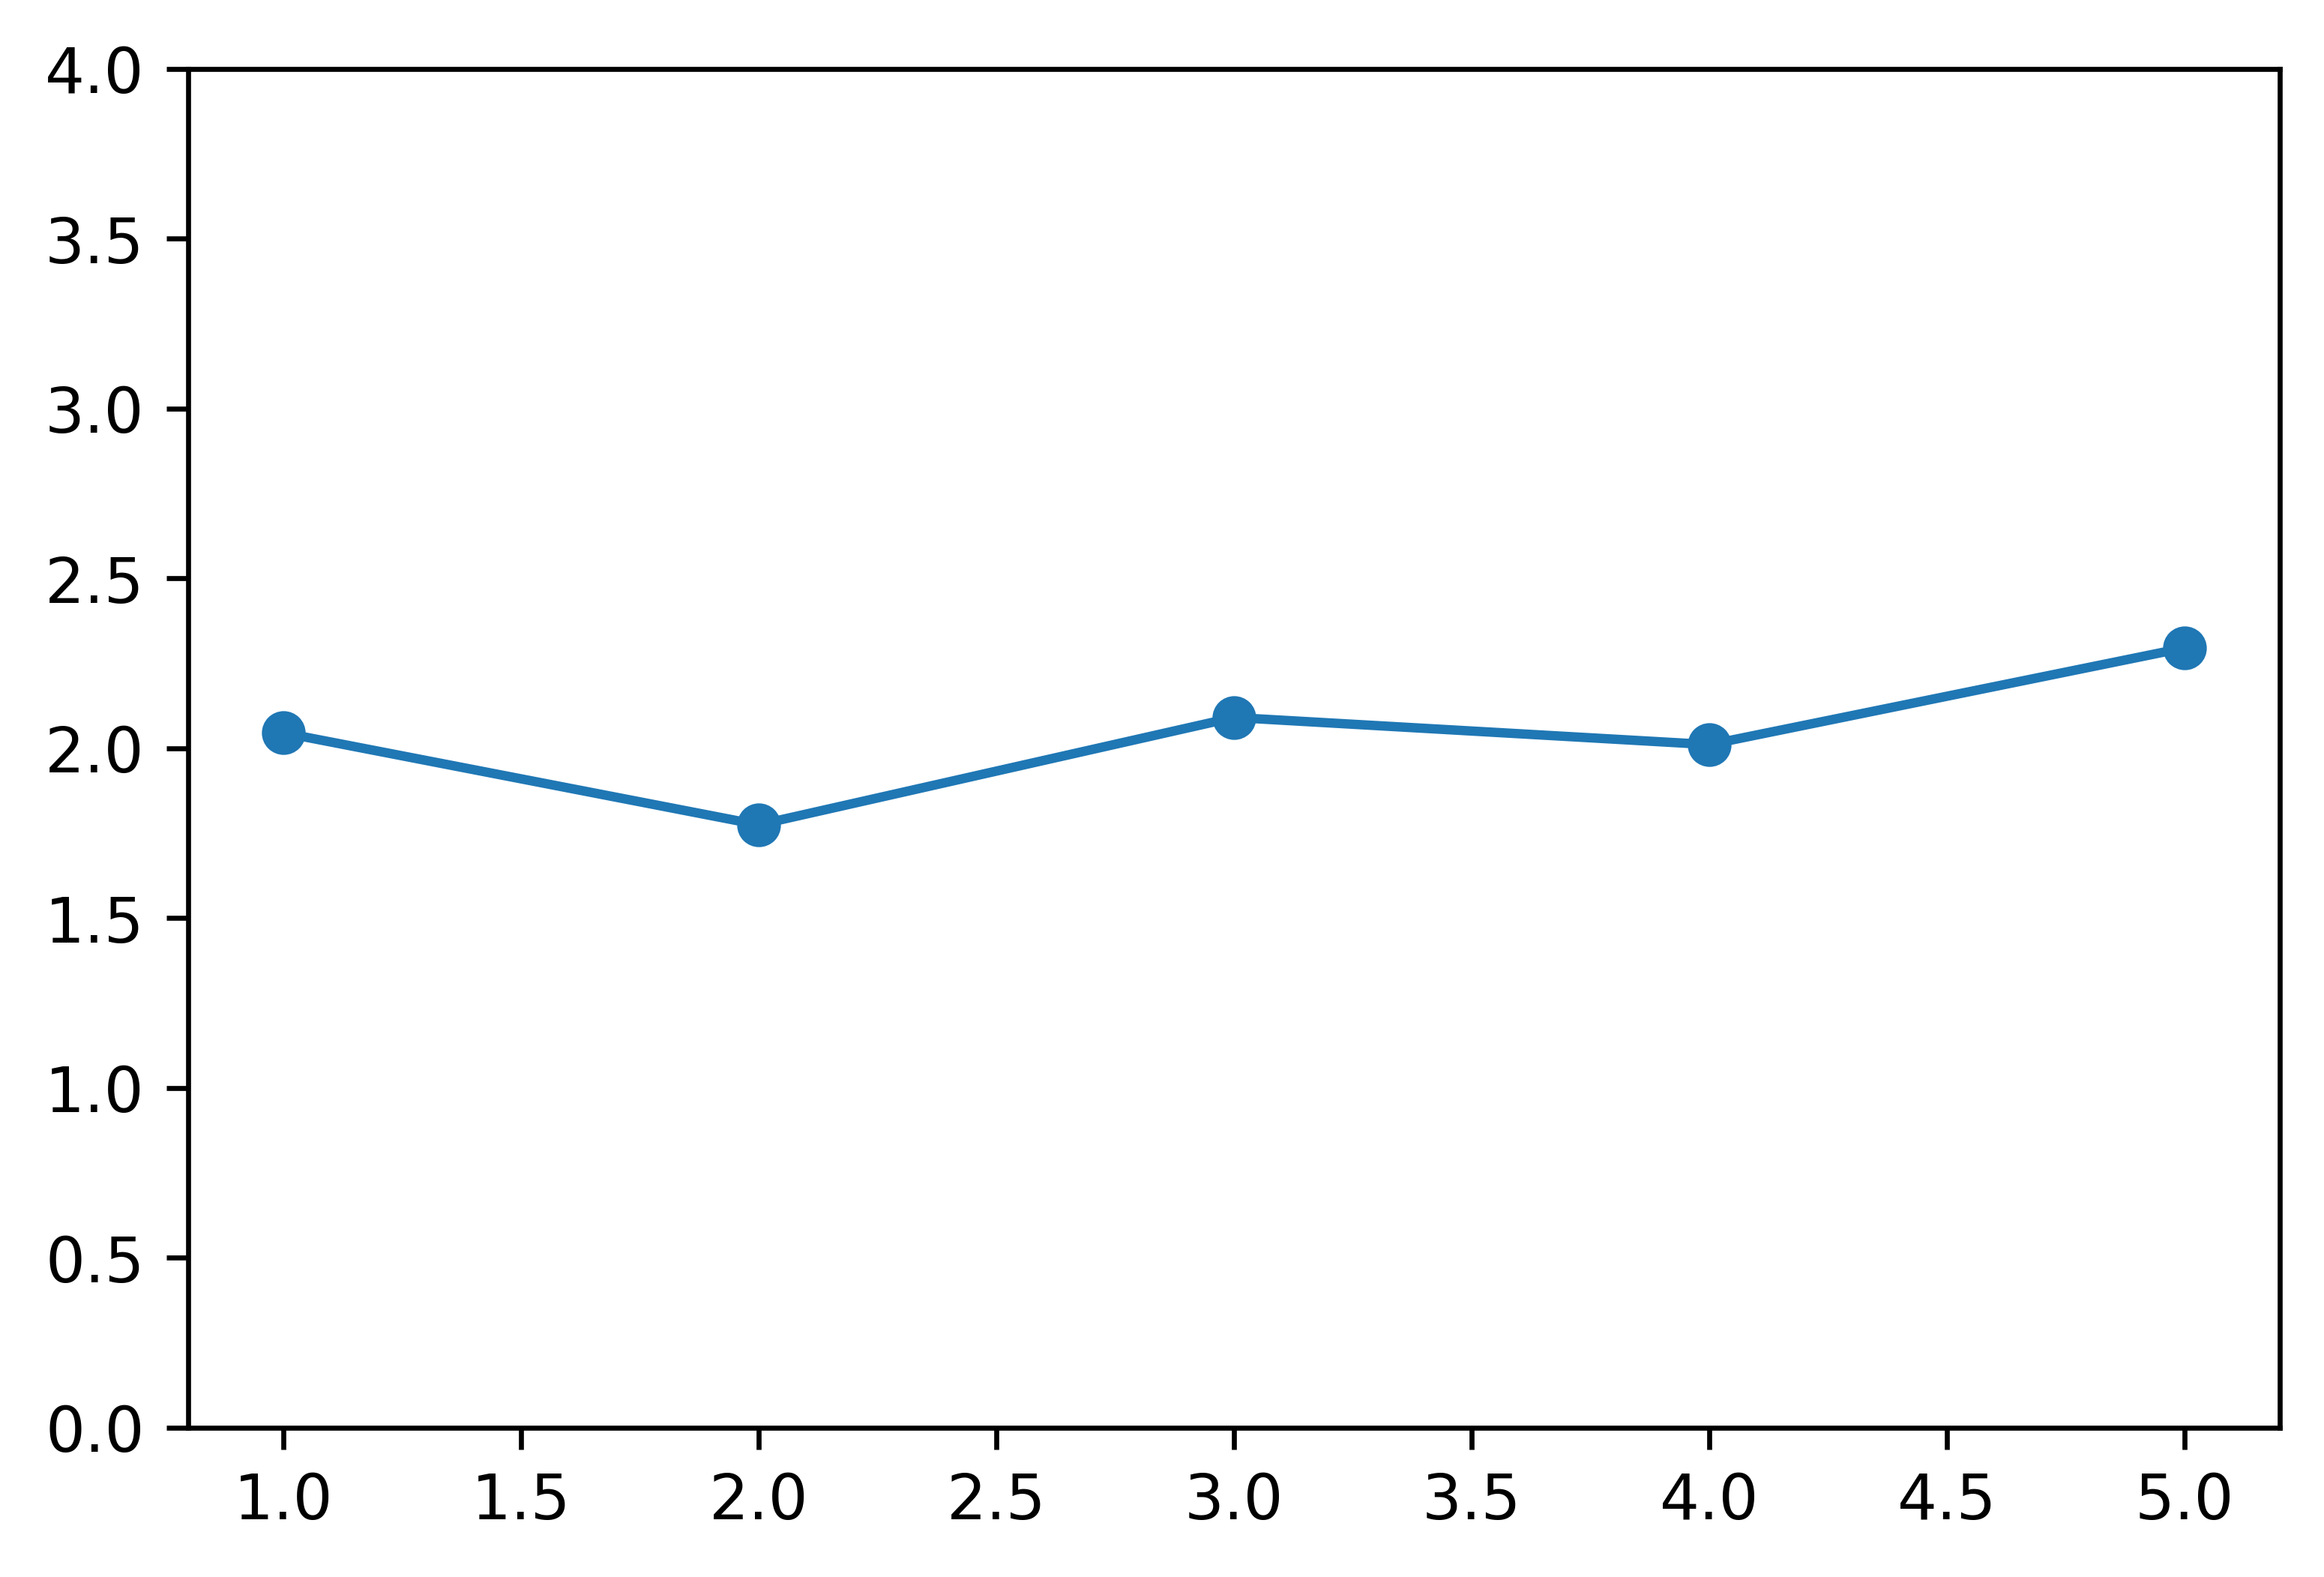

In [15]:
#Calcula a média
EJ_média = sum(sinais_das_EJs)/len(sinais_das_EJs)

#Joga no gráfico
EJ_média_em_C = EJ_média.para_a_base("C")
plt.plot(X[1:-1], EJ_média_em_C.pontos[1:-1])
plt.scatter(X[1:-1], EJ_média_em_C.pontos[1:-1])

#Define os limites do eixo y
plt.ylim((0, 4))


O que esse gráfico linear indica é que, na média, as dores se acumulam a cada cluster. Uma EJ de cluster 3, por exemplo, enxerga menos desafios de cluster 1 e 2 e mais desafios nas dores de cluster 4 e 5.

Seguindo com a PCA, subtrai-se a média de cada sinal para centralizá-los:

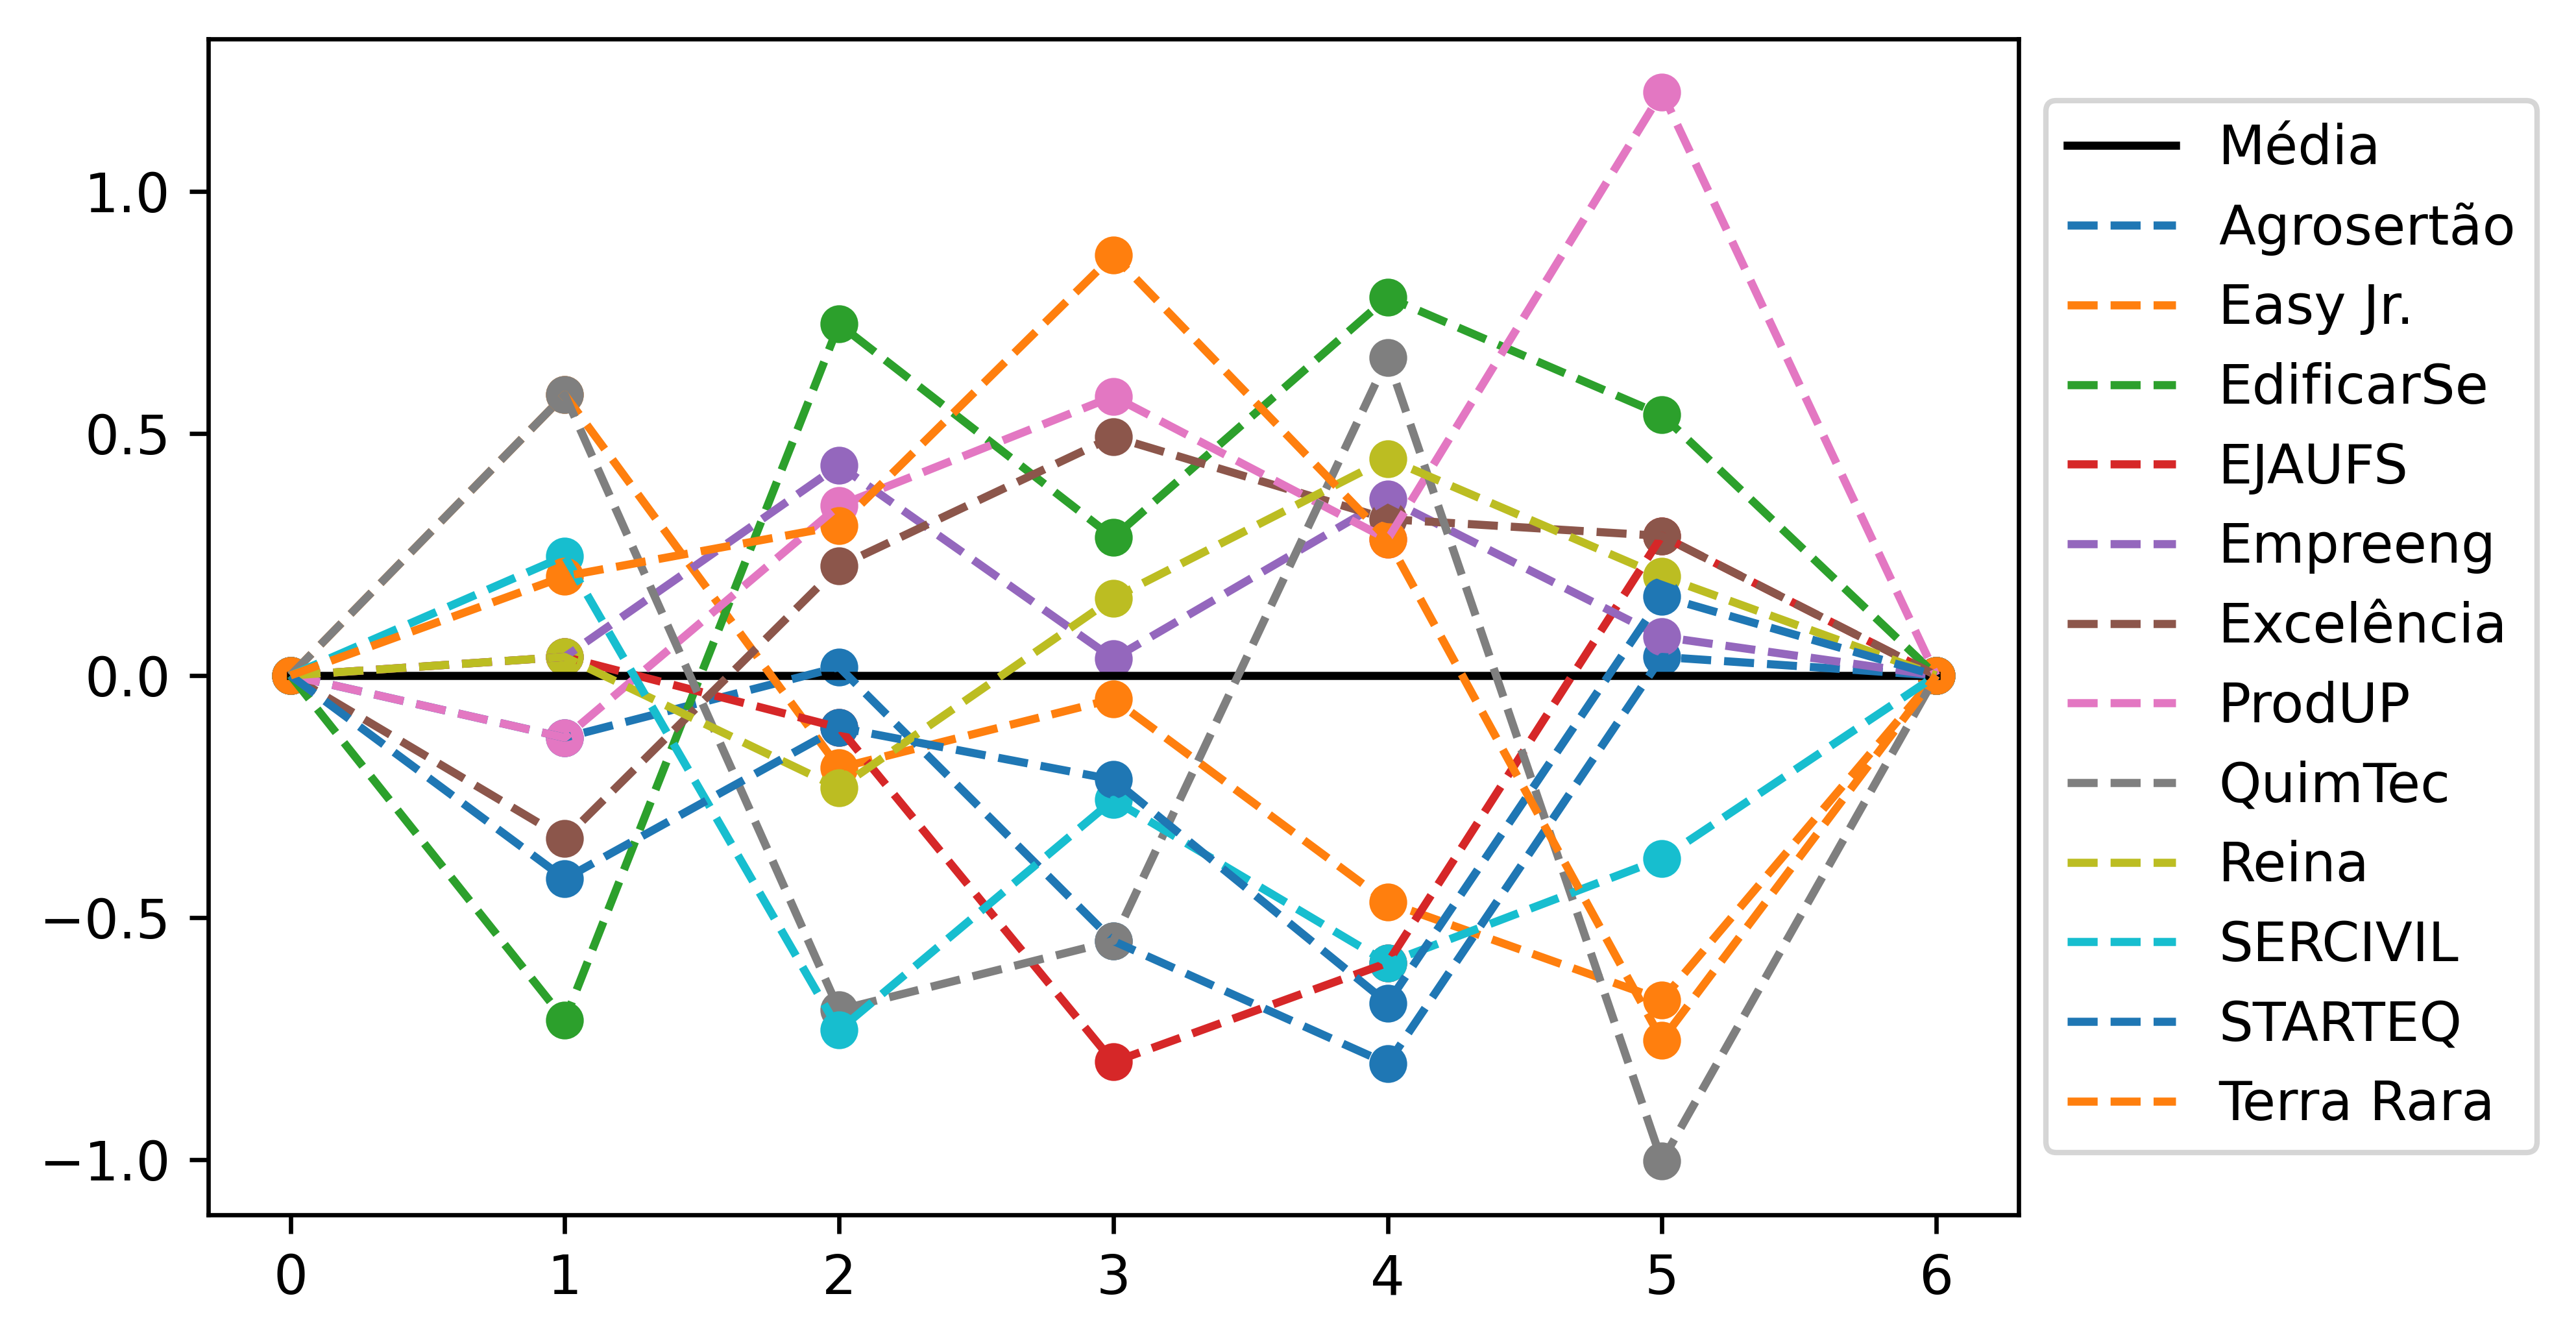

In [16]:
#Centraliza os sinais em relação à média
sinais_centrados = [EJ - EJ_média for EJ in sinais_das_EJs]

#Põe a média no gráfico em preto com traço cheio
plt.plot(X, [0] * 7, "black")

#Põe os sinais centrados no gráfico com traço vazado
for EJ in sinais_centrados:
    EJ = EJ.para_a_base("C")
    plt.plot(X, EJ.pontos, "--")
    plt.scatter(X, EJ.pontos)

#Adiciona a legenda
plt.legend(["Média"]
           + [sinal_de_EJ.name for sinal_de_EJ in sinais_das_EJs],
           loc="center left",
           bbox_to_anchor=(1, 0.5))

Encontrar as componentes principais consiste em determinar os eixos de maior variação a partir da média. Isto é feito a partir:

1. Da determinação da matriz de covariância. Ela estabelece como as dimensões dos dados estão relacionadas entre si.

2. Do cálculo dos autovetores e autovalores. Os autovetores representam os eixos, perpendiculares entre si, onde há maior variação. Seus autovalores representam quanto os dados variam na direção correspondente. 

In [38]:
#Traz a ferramenta de cálculo de autovetores e autovalores
from numpy.linalg import eig as auto

#Cálculo da matriz de covariância
cov = covariância_EJs = [
    [sum([sinais_centrados[k][i]
          * sinais_centrados[k][j]
                     for k in range(len(EJs))]
        )/len(EJs)
        
        for j in range(5)]
        for i in range(5)]

#Retorna as variâncias (autovalores) e suas
#correspondentes direções (autovetores)
variâncias, vetores = auto(cov)

#Consegue as posições das variâncias necessárias
#para que sejam dispostas em ordem decrescente
índices = variâncias.argsort()[::-1]

#Põe as variâncias e seus respectivos vetores em ordem decrescente
variâncias = variâncias[índices]
vetores = vetores[:, índices]

#Transforma as variâncias de vetores para números
variâncias = [float(var) for var in variâncias]

Para enxergar como a variância já calculada se distribui entre os eixos, constrói-se o ranking como abaixo:

In [39]:
#Cria o ranking mostrado abaixo
print("""
  Variância  Percentual
  
1ª vetor: {0:.2f}  | {5:.2f}% do total
2ª vetor:  {1:.2f}  |  {6:.2f}% do total 
3ª vetor:  {2:.2f}  |  {7:.2f}% do total 
4ª vetor:  {3:.2f}  |  {8:.2f}% do total 
5ª vetor:  {4:.3f} |  {9:.2f}% do total 
""".format(*variâncias, *[100 * var/sum(variâncias) for var in variâncias])
     )

vetores


  Variância  Percentual
  
1ª vetor: 1.40  | 87.22% do total
2ª vetor:  0.15  |  9.23% do total 
3ª vetor:  0.03  |  1.77% do total 
4ª vetor:  0.02  |  1.40% do total 
5ª vetor:  0.006 |  0.38% do total 



array([[ 0.1174796 ,  0.49332723,  0.18736716, -0.82505719, -0.16431972],
       [ 0.39006146,  0.3347374 ,  0.5175225 ,  0.24609556,  0.63828706],
       [ 0.5427056 ,  0.32519225,  0.00330095,  0.40404389, -0.66064988],
       [ 0.57342022, -0.05030783, -0.7249973 , -0.1793869 ,  0.33295289],
       [ 0.45903212, -0.73232386,  0.4140435 , -0.25156804, -0.1351768 ]])

Visualizar dados que tem 5 dimensões é um desafio, mas utilizando somente os 2 primeiros vetores como eixos (que contém juntos 99,5% de toda a variação) para representar os dados em apenas duas dimensões, pode-se ter uma compreensão mais simples e sem perda de profundidade. Os vetores que concentram a maior parte da variância se chamam "componentes principais".

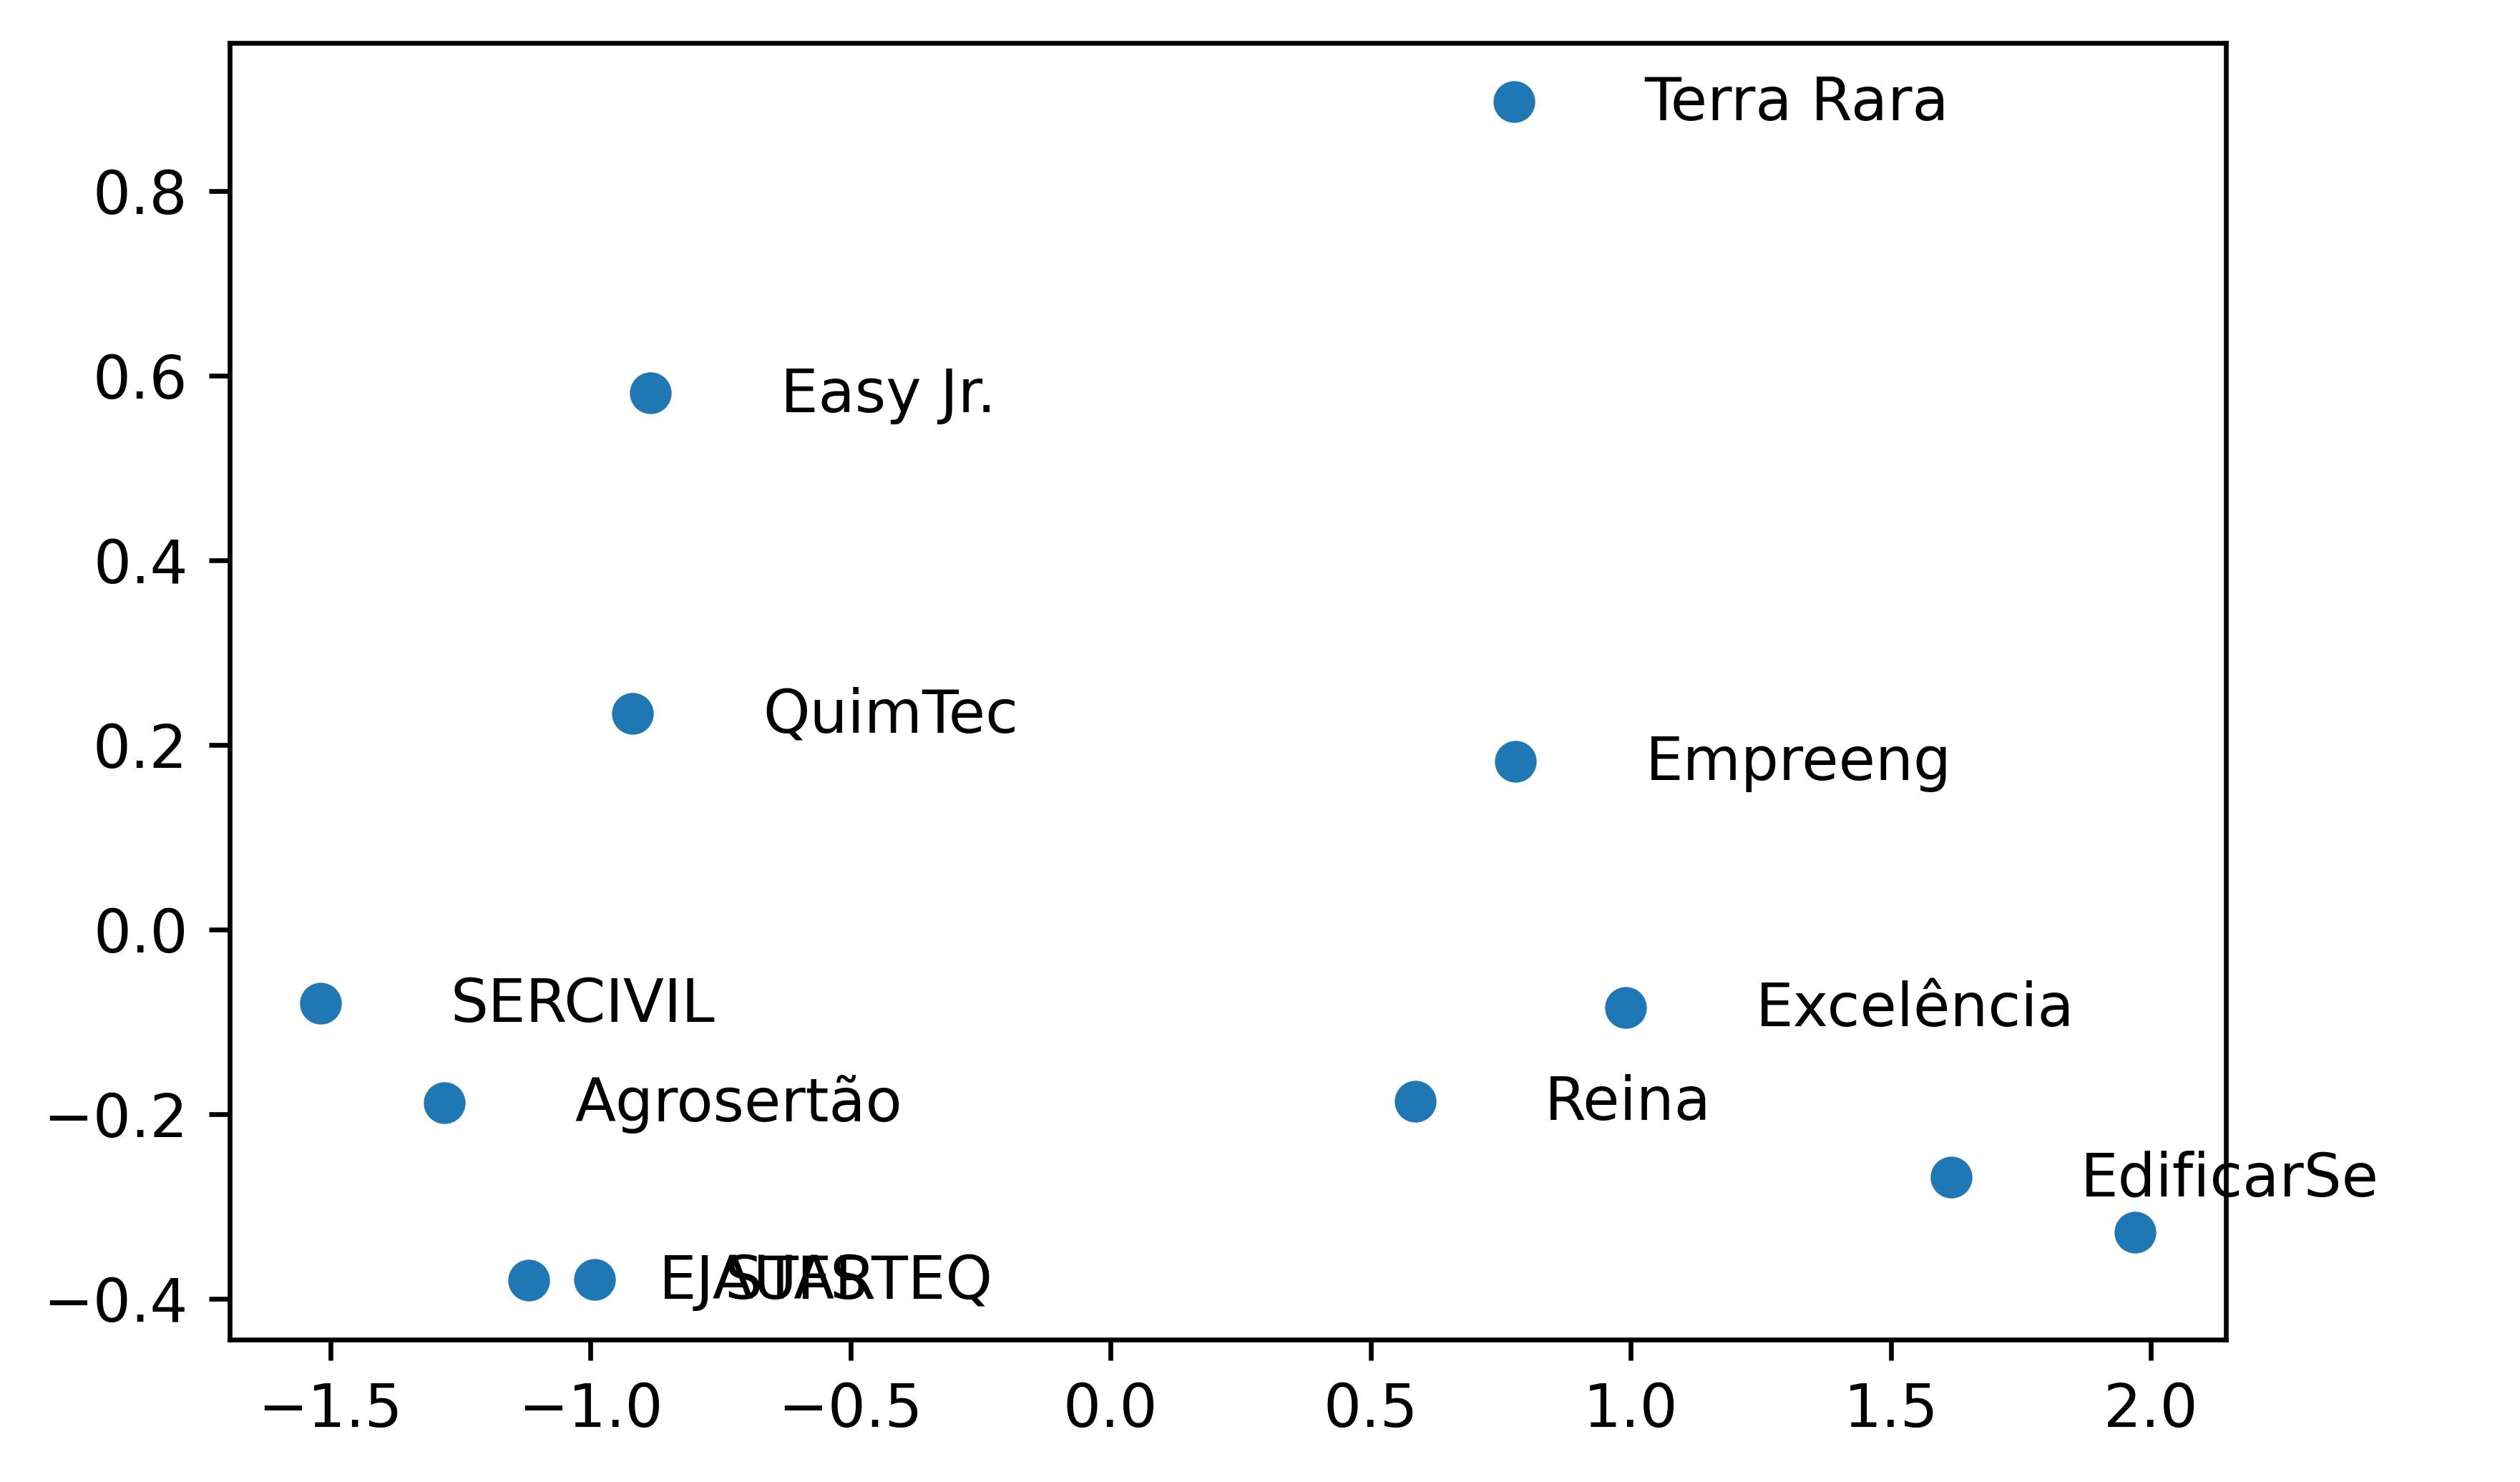

In [40]:
#Determina as coordenadas das projeções dos vetores das EJs
#no plano formado pelas 2 componentes principais
projeção = (vetores[:, [0, 1]].T
            @ np.hstack([sinal.T for sinal in sinais_centrados]))

#Gera o gráfico abaixo
plt.scatter(projeção[0], projeção[1])

#Adiciona o nome das EJs
for i, sinal in enumerate(sinais_das_EJs):
    plt.annotate(sinal.name, 
                 (projeção[0][i] + 0.25, projeção[1][i] - 0.02))

É interessante dividir as EJs em grupos de acordo com como elas se distribuíram no gráfico acima.

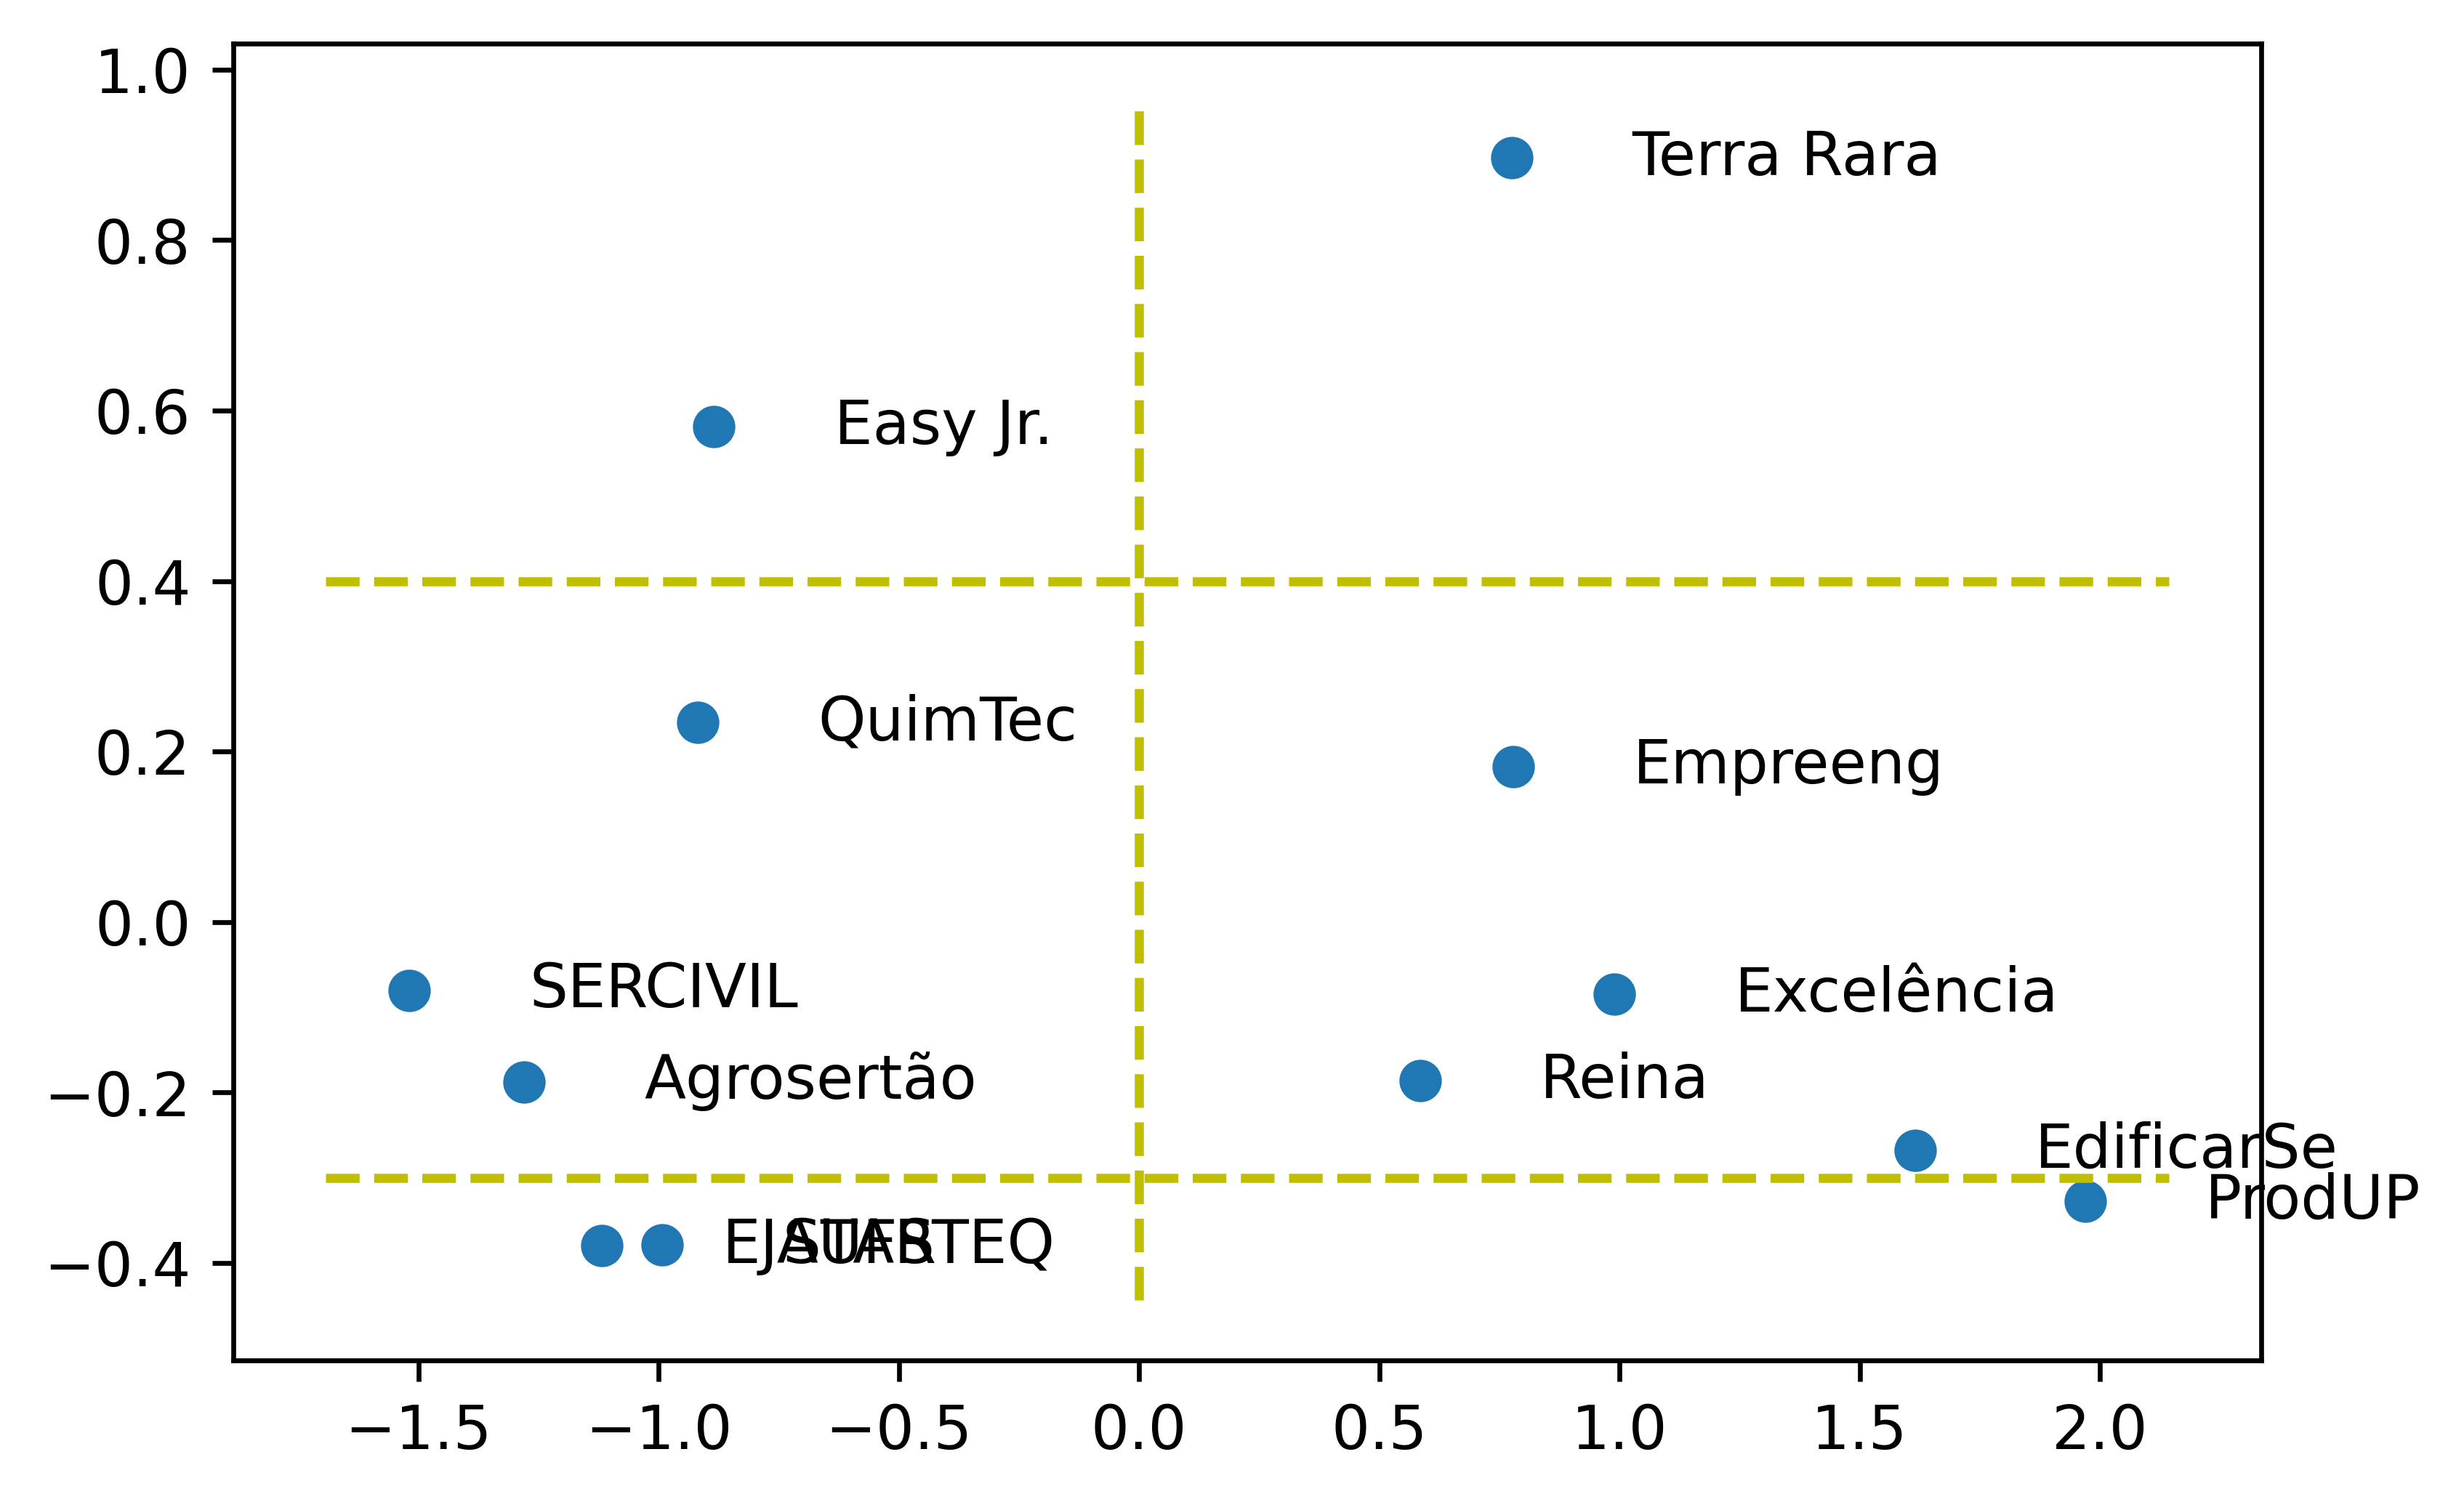

In [20]:
#Recria o gráfico acima
plt.scatter(projeção[0], projeção[1])

#Separa as EJs em grupos
for i, sinal in enumerate(sinais_das_EJs):
    x, y = projeção[0][i], projeção[1][i]
    if y > 0.4:
        if x < 0: sinal.grupo = "Grupo 1"
        else:     sinal.grupo = "Grupo 2"
    elif y >-0.3:
        if x < 0: sinal.grupo = "Grupo 3"
        else:      sinal.grupo ="Grupo 4"
    else:
        if x < 0: sinal.grupo = "Grupo 5"
        else:      sinal.grupo ="Grupo 6"
            
    plt.annotate(sinal.name, (x + 0.25, y - 0.02))

#Define os limites dos eixos (sem as margens)
y_lim_i, y_lim_s = plt.ylim()
x_lim_i, x_lim_s = plt.xlim()

#Traça as retas amarelas pontilhadas
plt.plot([x_lim_i, x_lim_s], [0.4, 0.4], "y--")
plt.plot([x_lim_i, x_lim_s], [-0.3, -0.3], "y--")
plt.plot([0, 0], [y_lim_i, y_lim_s], "y--")

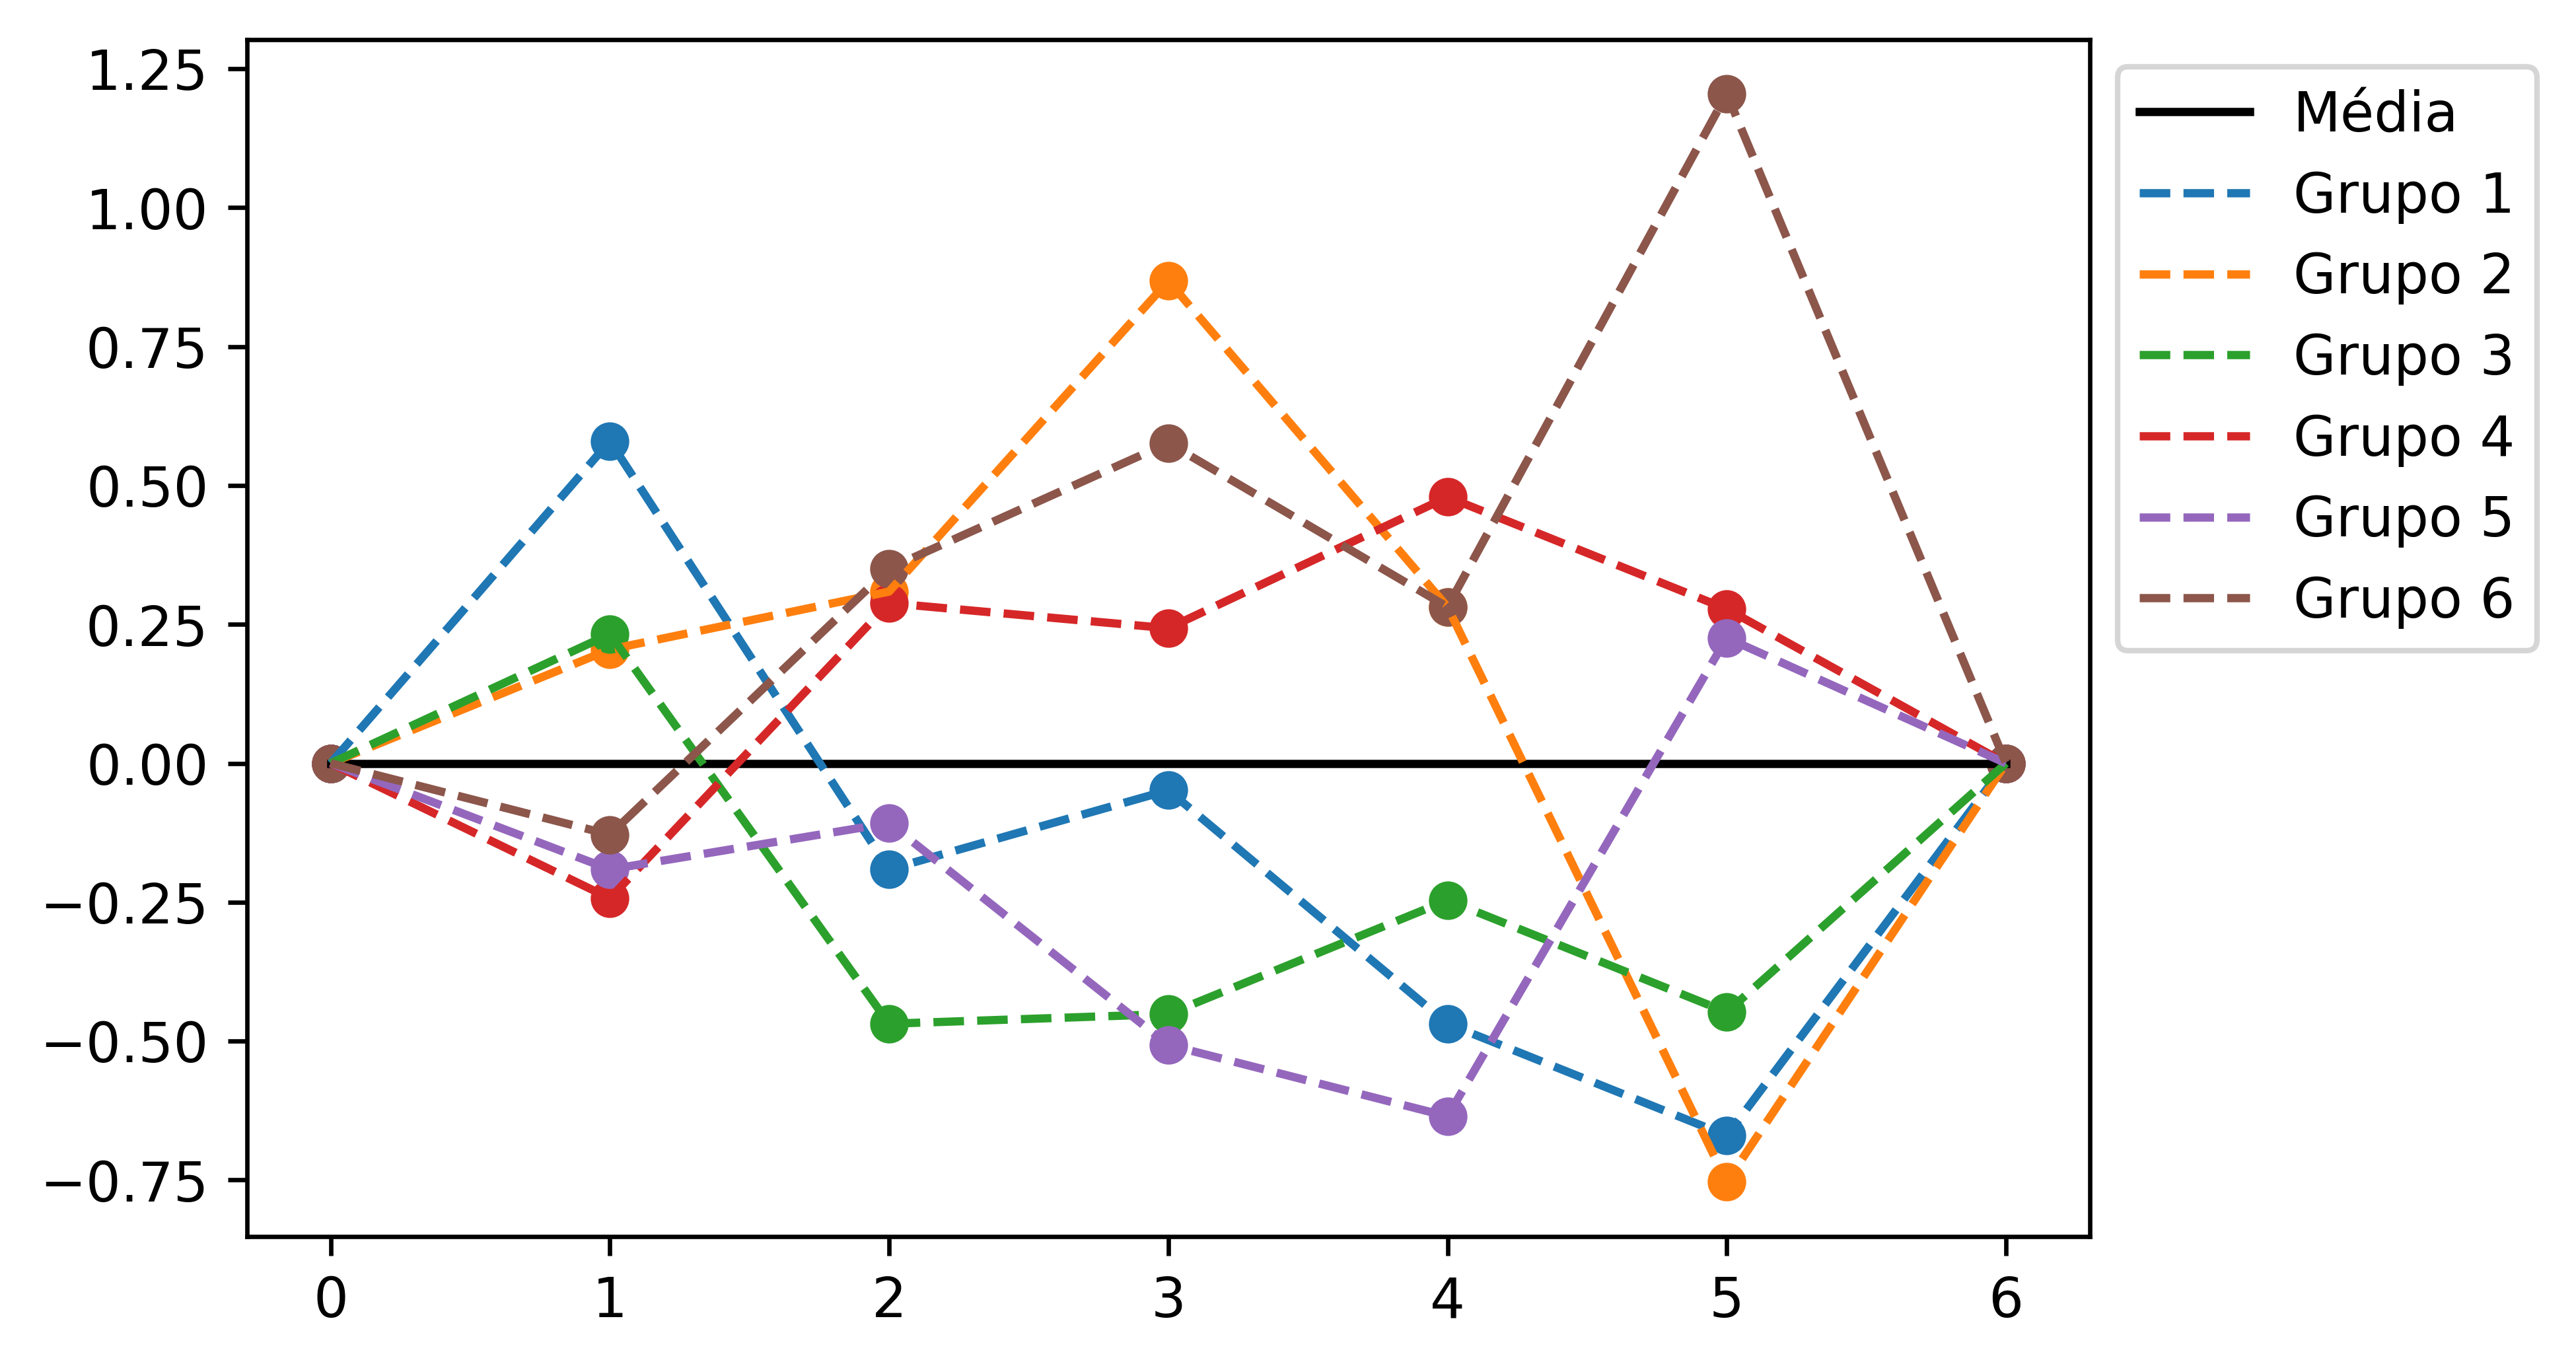

In [21]:
Média_Grupo = dict()

#Põe a média no gráfico em preto com traço cheio
plt.plot(X, [0] * 7, "black")

for i in range(1, 6 + 1):
    EJs_do_grupo = [EJ for EJ in sinais_das_EJs
                    if EJ.grupo == "Grupo {}".format(i)]
    Média_Grupo[i] = sum(EJs_do_grupo)/len(EJs_do_grupo)
    
for i in Média_Grupo:
    plt.plot(X, (Média_Grupo[i] - EJ_média).para_a_base("C").pontos, "--")
    plt.scatter(X, (Média_Grupo[i] - EJ_média).para_a_base("C").pontos)
    
plt.legend(["Média"]
           + ["Grupo {}".format(i) for i in range(1, 6 + 1)],
           bbox_to_anchor=(1, 1))

### Análise Fatorial

Esta técnica consiste em olhar para as respostas que estão mais correlacionadas e, a partir delas, inferir fatores ocultos. A premissa é que, se um mesmo grupo de perguntas quase sempre tem o mesmo padrão de respostas, existe algo por trás delas que faz com que elas estejam relacionadas. A este algo se dá o nome de "fator".

In [22]:
#Importa do R os dados não processados
%R -o entrada

#Mostra um recorte da tabela original
entrada.iloc[:, :35:5]

,EJs,MN_3_1,MN_5_2,VM_3_1,VM_5_2,GO_3_1,GO_5_2
1,Excelência,2,4,3,4,3,0
2,QuimTec,0,1,0,0,1,1
3,Empreeng,2,4,0,3,4,2
4,Terra Rara,4,4,2,1,4,0
5,STARTEQ,3,1,3,2,0,0
6,Easy Jr.,4,3,2,0,2,0
7,Reina,1,0,3,1,0,2
8,SERCIVIL,2,3,1,4,3,4
9,EJAUFS,2,2,2,3,0,2
10,ProdUP,4,4,0,4,3,3


Para garantir que a Análise Fatorial pode ser aplicada aos dados, realiza-se o teste Kaiser-Meyer-Olkin que deve resultar em um valor superior a **0,6**.

In [23]:
#Prepara os dados para análise
dados = pd.concat([entrada]*100)
dados.drop("EJs", axis=1, inplace=True)

#Traz o método de validação da Análise Fatorial para uso
from factor_analyzer.factor_analyzer import calculate_kmo as KMO

#Realiza o teste
_, kmo = KMO(dados)

#Mostra o resultado
"KMO dos dados: {:.3f}".format(kmo)

'KMO dos dados: 0.506'

Garantido que os dados comportam a análise, seleciona-se o número de fatores ocultos relevantes. Para tal, basta que eles possuam uma influência de ao menos uma unidade na variância dos dados.

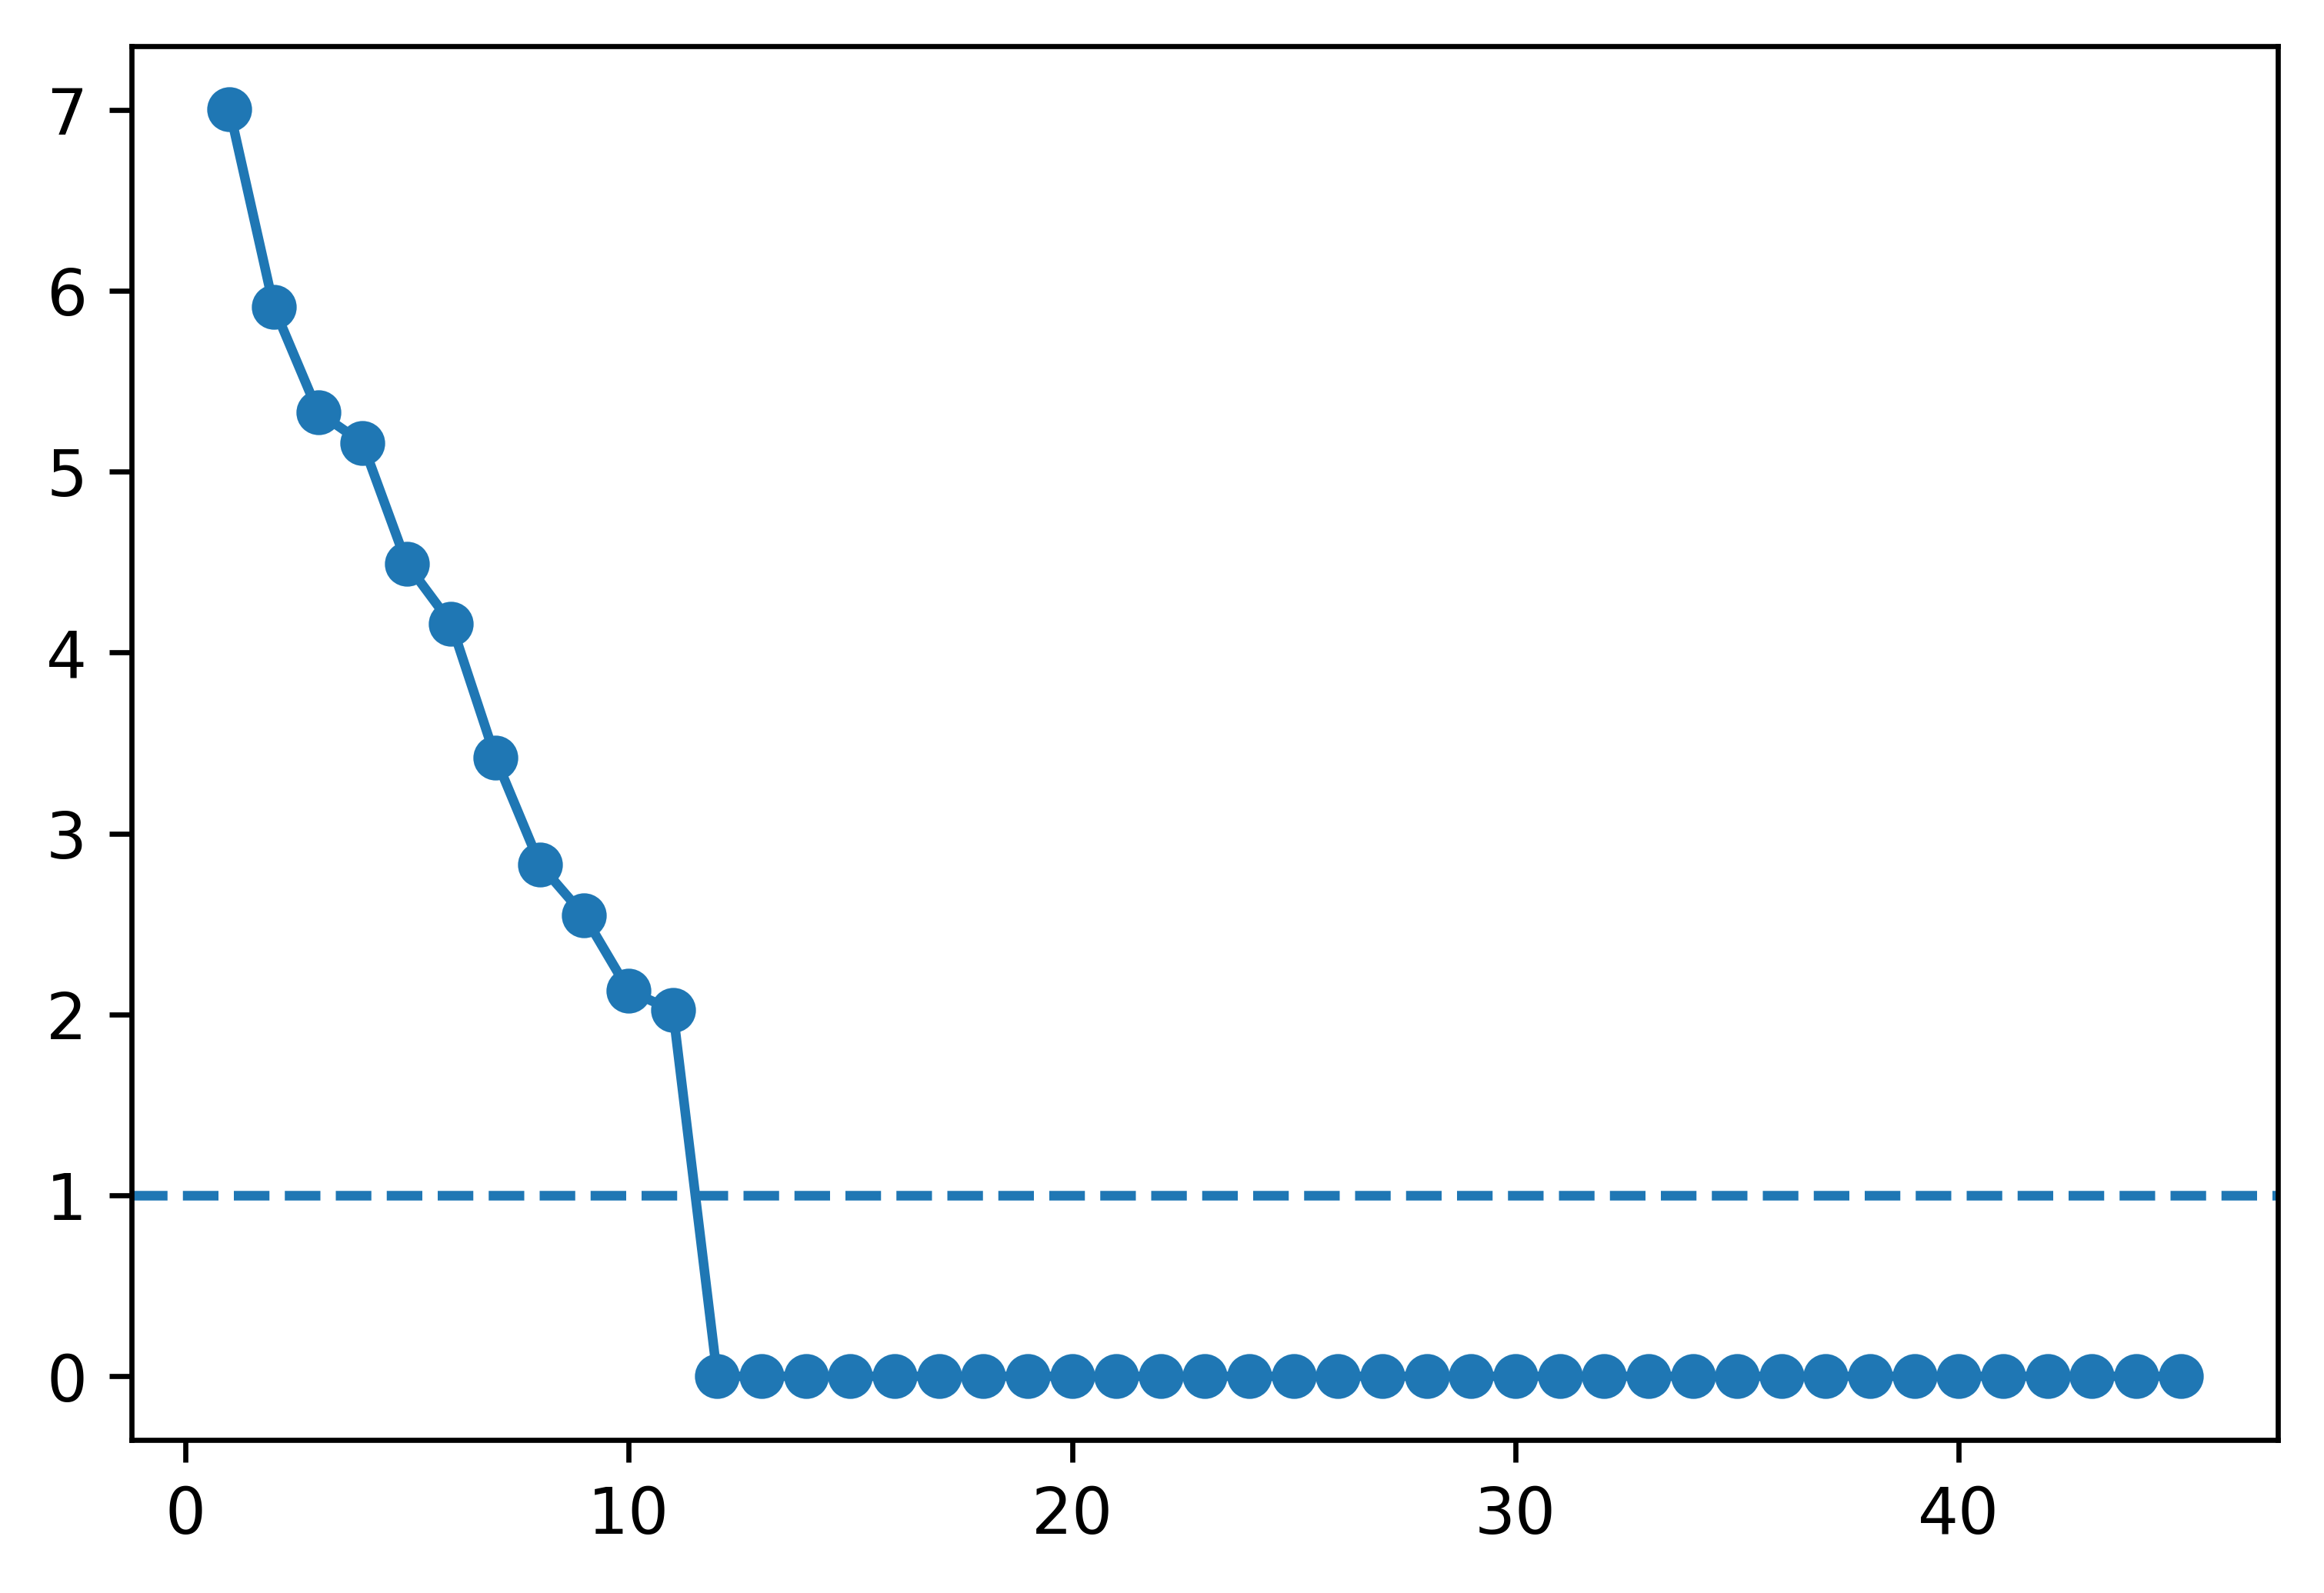

In [24]:
#Traz a ferramenta de Análise Fatorial para uso
from factor_analyzer import FactorAnalyzer

#Realiza a análise chutando que existem 10 fatores
#não observados de forma direta
fa = FactorAnalyzer(n_factors=10).fit(dados)

#Retorna as variância correspondentes
variâncias, vetores = fa.get_eigenvalues()

#Mostra as variâncias no gráfico abaixo
plt.scatter(range(1, len(variâncias) + 1), variâncias)
plt.plot(range(1, len(variâncias) + 1), variâncias)
plt.axhline(1, ls="--")

9 fatores se mostraram relevantes, isto é, ficaram acima da linha da variância 1. O próximo passo é entender em quais dores cada fator impacta:

In [25]:
#Realiza a análise considerando 9 fatores ocultos
fa = FactorAnalyzer(n_factors=9, rotation="varimax", method="ml").fit(dados)

#Forma uma tabela com o peso que cada fator tem em cada uma das dores
pesos = pd.DataFrame(fa.loadings_,
                     index=dados.columns,
                     columns=["Fator {}".format(i) for i in range(1, 9 + 1)])

#Mostra as dez primeiras linhas da tabela
pesos.head(10)

,Fator 1,Fator 2,Fator 3,Fator 4,Fator 5,Fator 6,Fator 7,Fator 8,Fator 9
MN_1_1,-0.158401,-0.213647,-0.280762,0.186600,-0.107126,-0.108832,0.572399,0.124196,0.163916
MN_1_2,-0.044371,0.242009,-0.440856,0.558827,-0.414735,-0.130278,0.166331,0.294191,0.257411
MN_2_1,-0.453396,0.638004,-0.056156,-0.272754,0.189902,0.224518,0.147194,0.108357,0.032774
MN_2_2,0.086662,-0.277119,0.289765,0.048506,0.399795,0.024883,-0.036266,0.736694,0.223025
MN_3_1,0.241568,0.228959,0.886069,0.056930,-0.089504,0.052870,0.028832,-0.070536,0.144720
MN_3_2,0.046288,-0.811737,-0.069413,0.389888,0.126750,-0.122616,-0.034436,0.206565,0.226924
MN_4_1,-0.003561,-0.694770,0.205827,0.000183,0.121816,-0.094838,0.233482,-0.309505,-0.242355
MN_4_2,0.101638,0.040377,-0.426816,0.153327,0.142539,0.738375,-0.363751,-0.214624,-0.036009
MN_5_1,0.088243,0.121955,-0.078398,-0.254819,0.264970,-0.071990,0.679263,0.069237,0.247592
MN_5_2,0.491764,0.032373,0.274575,-0.010249,-0.370067,-0.085341,-0.635387,0.270292,0.165920


Os números acima mostram a correlação entre cada dor e fator. A correlação é uma medida estatística que mede o quanto dois fenômenos se comportam de forma parecida. Uma correlação +1.0 indica uma associação perfeita, isto é, quando um dos fenômenos varia para cima o outro também o faz, na mesma proporção. Uma correlação de 0 indica que os dois são completamente independentes. Uma correlação de -1 indica uma associação também perfeita, porém quando um dos fenômenos varia numa direção o outro o faz na direção oposta e em mesma proporção .

Para cada fator, é interessante saber em quais dores este mais influencia, isto é, com quais dores ele mais se correlaciona em termos absolutos.

In [26]:
#Número de linhas da tabela
n = número_de_linhas = 10

#Cria uma tabela para o ranking inicialmente vazia
ranking = pd.DataFrame()

#Pega a lista de fatores a partir dos nomes
#das colunas da tabela de pesos
fatores = pesos.columns

#Para cada fator dentre todos os fatores
for fator in fatores:
    
    #Gera as posições de cada correlação na forma ordenada
    ordenação = np.array([abs(p) for p in pesos[fator]]).argsort()[::-1]
    
    #Coloca dentro da tabela do ranking as 10 primeiras
    #dores de acordo com a ordenação
    ranking[fator] = pesos.index[ordenação][:n]
    
    #Coloca dentro da tabela do ranking as influências (ou correlações)
    #de cada uma das primeiras dores
    ranking["Inf. de F{}".format(fator[-1])] = np.array(pesos[fator])[ordenação][:n]
    
#Gera os índices do ranking
ranking.index = range(1, número_de_linhas + 1)

#Mostra a tabela abaixo
ranking

,Fator 1,Inf. de F1,Fator 2,Inf. de F2,Fator 3,Inf. de F3,Fator 4,Inf. de F4,Fator 5,Inf. de F5,Fator 6,Inf. de F6,Fator 7,Inf. de F7,Fator 8,Inf. de F8,Fator 9,Inf. de F9
1,TC_3_3,0.870887,TC_2_3,0.942106,VM_2_2,0.899602,TC_3_2,0.840180,TC_5_2,0.910554,TC_5_1,0.907047,GO_2_1,-0.816392,TC_2_1,-0.863129,TC_1_3,-0.868910
2,GO_3_1,0.847029,VM_1_2,-0.917777,MN_3_1,0.886069,GO_5_2,-0.836695,VM_5_1,0.875297,MN_4_2,0.738375,MN_5_1,0.679263,MN_2_2,0.736694,VM_4_2,0.824772
3,GO_3_2,0.763592,MN_3_2,-0.811737,GO_5_3,0.850879,TC_1_1,0.832892,VM_4_1,0.722931,VM_3_2,0.693657,MN_5_2,-0.635387,VM_3_2,-0.381388,VM_4_1,0.386801
4,GO_5_1,-0.744883,MN_4_1,-0.694770,TC_3_1,0.672929,VM_5_2,-0.692344,TC_2_2,0.669474,GO_4_1,0.667973,TC_4_2,-0.608469,TC_1_2,0.368044,VM_3_1,-0.348583
5,GO_2_2,0.661395,MN_2_1,0.638004,VM_2_1,0.500757,GO_4_2,-0.592069,GO_1_2,-0.590996,TC_1_2,0.609184,VM_1_1,-0.596619,MN_4_1,-0.309505,GO_3_2,-0.341430
6,VM_2_1,0.525730,TC_1_2,0.585974,TC_4_2,-0.483597,MN_1_2,0.558827,VM_3_1,0.523509,GO_1_1,-0.577167,MN_1_1,0.572399,GO_1_1,-0.296289,VM_1_1,0.336885
7,GO_4_1,0.507071,TC_4_3,-0.554546,VM_3_2,-0.461876,VM_1_1,-0.403683,TC_4_1,0.486539,GO_2_2,0.551437,GO_1_1,0.466991,MN_1_2,0.294191,TC_2_2,-0.300295
8,TC_4_1,0.505184,GO_4_2,0.500315,TC_4_3,-0.449461,TC_3_1,0.400463,MN_1_2,-0.414735,GO_1_2,0.512232,MN_4_2,-0.363751,GO_5_3,-0.288441,TC_2_1,0.259769
9,MN_5_2,0.491764,TC_4_2,0.466300,MN_1_2,-0.440856,MN_3_2,0.389888,TC_4_3,0.406369,VM_1_1,-0.511909,GO_4_2,0.339333,GO_4_2,0.286908,MN_1_2,0.257411
10,MN_2_1,-0.453396,VM_3_1,0.360449,MN_4_2,-0.426816,TC_2_2,0.381642,MN_2_2,0.399795,TC_1_1,-0.311119,GO_5_3,-0.338274,MN_5_2,0.270292,MN_5_1,0.247592


Para entender a relevância de cada um desses fatores nas respostas como um todo, é possível calcular a influência que estes tem nas 10 dores com as quais estão mais correlacionados.

In [27]:
#Soma os quadrados das correlações para cada
#fator e mostra o resultado logo abaixo
ranking.iloc[:, 1::2].apply(
    lambda x: "{:.2f}%".format(10 * sum([a**2 for a in x])))

Inf. de F1    42.87%
Inf. de F2    45.27%
Inf. de F3    40.48%
Inf. de F4    38.63%
Inf. de F5    39.23%
Inf. de F6    39.25%
Inf. de F7    31.65%
Inf. de F8    20.77%
Inf. de F9    22.22%
dtype: object

Pela disposição dos dados, e também por ser preferível trabalhar com menos agrupamentos, cabe limitar a análise aos fatores que tem no mínimo 30% de influência no resultado inicial, isto é, os 5 primeiros.

É necessário portanto refazer a análise considerando apenas 5 fatores.

In [28]:
#Realiza a análise considerando 5 fatores ocultos
fa = FactorAnalyzer(n_factors=5, rotation="varimax", method="ml").fit(dados)

#Forma uma tabela com o peso que cada fator tem em cada uma das dores
pesos = pd.DataFrame(fa.loadings_,
                     index=dados.columns,
                     columns=["Fator {}".format(i) for i in range(1, 5 + 1)])

#Cria uma tabela para o ranking inicialmente vazia
ranking = pd.DataFrame()

#Pega a lista de fatores a partir dos nomes
#das colunas da tabela de pesos
fatores = pesos.columns

#Para cada fator dentre todos os fatores
for fator in fatores:
    
    #Gera as posições de cada correlação na forma ordenada
    ordenação = np.array([abs(p) for p in pesos[fator]]).argsort()[::-1]
    
    #Coloca dentro da tabela do ranking as
    #dores de acordo com a ordenação
    ranking[fator] = pesos.index[ordenação]
    
    #Coloca dentro da tabela do ranking as influências
    #(ou correlações) de cada uma das primeiras dores
    ranking["Inf. de F{}".format(fator[-1])] = np.array(pesos[fator])[ordenação]
    
#Gera os índices do ranking
ranking.index = range(1, 45 + 1)

#Mostra a tabela abaixo
ranking.head(10)

,Fator 1,Inf. de F1,Fator 2,Inf. de F2,Fator 3,Inf. de F3,Fator 4,Inf. de F4,Fator 5,Inf. de F5
1,GO_4_2,-0.815725,VM_5_1,0.840968,TC_1_2,0.839495,VM_2_2,0.831988,GO_3_2,0.835032
2,TC_3_2,0.813251,MN_5_2,-0.798849,GO_4_1,0.775935,GO_5_3,0.813721,TC_3_3,0.806889
3,MN_3_2,0.781491,TC_5_2,0.791321,GO_2_2,0.715510,MN_3_1,0.809769,TC_4_1,0.617167
4,VM_1_2,0.718668,GO_3_1,-0.722479,TC_2_3,0.705694,VM_2_1,0.622369,GO_1_1,0.588917
5,GO_5_2,-0.692794,VM_3_1,0.618191,MN_4_2,0.628332,TC_3_1,0.615062,TC_4_3,0.559524
6,VM_5_2,-0.656187,GO_5_1,0.551531,TC_5_1,0.567336,MN_1_2,-0.608126,GO_3_1,0.503039
7,VM_4_1,0.589145,GO_2_1,-0.524568,MN_4_1,-0.516913,TC_4_2,-0.437892,TC_2_2,0.491914
8,MN_2_1,-0.517078,GO_1_2,-0.504272,TC_1_3,-0.442141,VM_3_2,-0.426216,GO_5_1,-0.479211
9,TC_1_1,0.465444,MN_5_1,0.503708,GO_5_1,-0.424317,MN_2_2,0.415694,VM_5_2,0.439553
10,MN_4_1,0.453177,MN_2_1,0.503563,TC_4_2,0.400655,VM_5_2,0.384637,VM_2_2,-0.425825


Para atribuir significado a cada fator, pode-se, finalmente, checar quais são as dores em que mais influenciam

In [30]:
#Importa as descrições das dores da planilha na pasta "dados"
descrição = pd.read_csv(os.path.join("c_dados", "descrição_das_dores.csv"))

#Para cada fator dentre todos os fatores
for fator in fatores:
    
    #Mostra, ali embaixo, qual fator está sendo analisado
    print("Dores associadas ao Fator {}:\n".format(fator[-1]))
    
    #Para um índice que varia de 1 a 5
    for i in range(1, 5 + 1):
        
        #Mostra a dor correspondente ao índice do ranking
        print("{}. {: .2f}% - {}: {}\n".format(
              i,
              100 * ranking["Inf. de F{}".format(fator[-1])][i],
              ranking[fator][i],
              descrição[ranking[fator][i]][0]))
        
    #Separa duas linhas entre fatores
    print("\n\n")

Dores associadas ao Fator 1:

1. -81.57% - GO_4_2: Não conseguimos inovar e explorar oportunidades no nosso modelo de negócios para ganhar competitividade no mercado.

2.  81.33% - TC_3_2: Nossos membros são pouco proativos em empreenderem mudanças importantes para a nossa EJ.

3.  78.15% - MN_3_2: Não somos ágeis no gerenciamento dos nossos projetos.

4.  71.87% - VM_1_2: Não temos um processo de vendas estruturado, nem um bom volume de negociação.

5. -69.28% - GO_5_2: Nosso design organizacional não é completamente voltado para gerar o maior valor para o cliente.




Dores associadas ao Fator 2:

1.  84.10% - VM_5_1: Não realizamos investimentos em estruturas que torne nosso processo de vendas mais inteligente e automatizado.

2. -79.88% - MN_5_2: Não conseguimos desenvolver inovações disruptivas (que quebram padrões) e criativas para se destacar no mercado.

3.  79.13% - TC_5_2: Não conseguimos garantir a melhor performance de todos os membros reforçada pela cultura forte da EJ.

4

In [31]:
#Normaliza as linhas da entrada
dados = entrada.set_index("EJs")
dados["soma"] = dados.sum(axis=1)
dados = dados.iloc[:, :45].div(dados["soma"], axis=0)

#Aplica o peso de cada fator a cada resposta normalizada
#onde o peso é maior que 0.5
resultado = pd.DataFrame(dados.values
                         @ pesos.applymap(lambda x: x if abs(x) > 0.5 else 0).values)

#Nomeia as linhas com suas respectivas EJs
resultado.index = entrada["EJs"]

#Nomeia as colunas com os fatores
resultado.columns =["Fator {}".format(i) for i in range(1, 5 + 1)]

#Mostra a tabela abaixo, em termos absolutos
resultado

,Fator 1,Fator 2,Fator 3,Fator 4,Fator 5
EJs,,,,,
Excelência,0.059636,0.006689,0.088334,0.080244,0.088944
QuimTec,0.134783,0.005337,0.056336,-0.014930,0.070892
Empreeng,-0.057111,-0.040281,0.171002,0.012548,0.120418
Terra Rara,0.079372,-0.032552,0.128419,0.063002,0.138254
STARTEQ,0.034680,0.133721,0.034267,0.112114,0.074675
Easy Jr.,0.092006,-0.001917,0.092412,0.129629,0.019324
Reina,0.057212,0.133749,0.093025,0.016969,0.110597
SERCIVIL,-0.094193,-0.033256,0.015978,0.072994,0.151994
EJAUFS,-0.025919,0.136878,0.055577,0.028146,0.056609


In [32]:
#Padroniza os resultados
resultado_padronizado = pd.DataFrame([(c - c.mean())/c.std()
                                      for c in [resultado[col]
                                                for col in resultado]]).T

#Diz ao Python como queremos que calcule os percentis
from scipy.stats import norm
percentil = norm.cdf

#Retorna o resultado em percentis
resultado_em_percentis = \
    resultado_padronizado.applymap(lambda x: "{:.1f}%".format(100 * percentil(x)))

#Mostra a tabela abaixo
resultado_em_percentis

,Fator 1,Fator 2,Fator 3,Fator 4,Fator 5
EJs,,,,,
Excelência,70.2%,35.5%,51.2%,60.8%,53.1%
QuimTec,95.0%,34.8%,26.0%,4.0%,36.8%
Empreeng,11.4%,14.8%,96.2%,12.1%,78.8%
Terra Rara,79.5%,17.6%,80.9%,46.2%,88.6%
STARTEQ,56.3%,92.6%,13.4%,83.0%,40.1%
Easy Jr.,84.4%,31.1%,54.6%,90.8%,6.4%
Reina,69.0%,92.6%,55.2%,14.1%,71.7%
SERCIVIL,3.9%,17.3%,6.8%,54.7%,93.6%
EJAUFS,22.9%,93.2%,25.5%,20.1%,25.3%


Quais as EJs mais influenciadas por cada fator?

In [33]:
#Cria uma tabela vazia para o ranking
ranking_de_dores = pd.DataFrame()

#Começa com o fator 1
i = 1

#Recupera os nomes dos fatores a partir
#das colunas da tabela acima
fatores = resultado.columns

#Para cada fator dentre os fatores
for fator in fatores:
    
    #Gera os índices que ordenam as influências
    ordenação = np.array([p for p in resultado[fator]]).argsort()[::-1]
    
    #Adiciona as EJs na coluna do fator e na ordem correta
    ranking_de_dores[fator] = resultado.index[ordenação]
    
    #Adiciona as influências que o fator tem em cada EJ
    ranking_de_dores["Influência de F{}".format(i)] = \
        np.array(resultado_em_percentis[fator])[ordenação]
    
    #Passa para o índice do próximo fator
    i += 1
    
#Adiciona a numeração do ranking
ranking_de_dores.index = list(range(1, 12 + 1))

#Mostra a tabela como abaixo (5 primeiras linhas)
ranking_de_dores.head()

,Fator 1,Influência de F1,Fator 2,Influência de F2,Fator 3,Influência de F3,Fator 4,Influência de F4,Fator 5,Influência de F5
1,QuimTec,95.0%,EJAUFS,93.2%,Empreeng,96.2%,Easy Jr.,90.8%,SERCIVIL,93.6%
2,Easy Jr.,84.4%,Reina,92.6%,EdificarSe,91.3%,ProdUP,84.8%,Terra Rara,88.6%
3,Terra Rara,79.5%,STARTEQ,92.6%,Terra Rara,80.9%,STARTEQ,83.0%,ProdUP,79.3%
4,Excelência,70.2%,EdificarSe,78.7%,Agrosertão,67.7%,EdificarSe,80.2%,Empreeng,78.8%
5,Reina,69.0%,ProdUP,37.4%,Reina,55.2%,Agrosertão,65.0%,Reina,71.7%


Para verificar a situação de cada EJ em particular, é interessante gerar uma tabela para cada fator que deixe claro:

1. Quanto cada fator influencia a EJ (como acima);
2. Como cada EJ respondeu as questões que tem mais peso para o fator.

In [36]:
#Para cada coluna acima, saltando de duas em duas,
#recupera seu índice
for i in range(0, 10, 2):
    
    #Cria uma tabela vazia
    tabela = pd.DataFrame()
    
    #Recupera as dores do fator correspondente
    dores = ranking.iloc[:9, i]
    
    #Começa na primeira linha do ranking de dores
    j = 0
    
    #Para cada EJ no ranking de dores do fator em análise
    for EJ in ranking_de_dores.iloc[:, i]:
        
        #Recupera as respostas da EJ sobre as dores associadas ao fator
        respostas = dados.loc[EJ, dores].apply(lambda x: "{:.2f}".format(100 * x))
        
        #Determina o nome da linha na tabela
        respostas.name = "({}) {}".format(ranking_de_dores.iloc[j, i + 1], EJ)
        
        #Adiciona as respostas da EJ como uma linha na tabela
        tabela = tabela.append(respostas)
        
        #Atualiza o índice da linha
        j += 1
    
    #Reorganiza as colunas da tabela
    tabela = tabela.loc[:, dores]
    
    #Adiciona a informação da influência que a dor tem no fator
    tabela.columns = ["{} ({:.2f}%)".format(dor, 100 * inf)
                      for dor, inf in zip(dores, ranking.iloc[:9, i + 1])]
    
    #Joga a tabela num arquivo CSV com o nome do fator
    #na pasta "resultados/fatores/"
    tabela.to_csv(os.path.join("c_resultado",
                               "c_fatores",
                               "_".join(ranking_de_dores.columns[i].split())
                               + ".csv"))